# Optimizing Delivery Zones Using Geospatial Analytics

## Project Background

Efficient delivery operations are critical for Zomato to ensure timely service and control costs. When orders are geographically scattered, drivers travel longer distances, and delivery times become inconsistent. Using geospatial clustering, Zomato can create optimized delivery zones to improve routing, reduce operational costs, and enhance delivery performance.

## Bussiness Problem

Zomato currently faces:

* Longer delivery distances and higher costs: Drivers travel across wide areas, increasing fuel and labor expenses.

* Inconsistent delivery times: Variability in routes and external factors like traffic or weather causes delays, reducing customer satisfaction.

* Limited operational visibility: Without data-driven delivery zones, it is difficult to plan resources effectively and optimize routing.

The company needs a solution to define optimized delivery zones that minimize travel, reduce costs, and improve delivery consistency.


## Objectives
* Reduce delivery distances and operational costs: Cluster customer locations into optimized delivery zones to minimize driver travel.

* Improve delivery consistency: Evaluate SLA per cluster and design zones that support predictable and on-time deliveries.

* Enable data-driven decision making: Provide insights for assigning delivery zones and planning resources efficiently.

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium


from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from folium.plugins import MarkerCluster

## Data Understanding

In [ ]:
#Import dataset
df_zamato = pd.read_csv('/content/Zomato Dataset.csv')
df_zamato.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


| Column Name                   | Description                                                      |
|-------------------------------|------------------------------------------------------------------|
| ID                            | Unique identifier for each delivery.                             |
| Delivery_person_ID            | Unique identifier for each delivery person.                      |
| Delivery_person_Age           | Age of the delivery person.                                      |
| Delivery_person_Ratings       | Ratings assigned to the delivery person.                         |
| Restaurant_latitude           | Latitude of the restaurant.                                      |
| Restaurant_longitude          | Longitude of the restaurant.                                     |
| Delivery_location_latitude    | Latitude of the delivery location.                               |
| Delivery_location_longitude   | Longitude of the delivery location.                              |
| Order_Date                    | Date of the order.                                               |
| Time_Ordered                  | Time the order was placed.                                       |
| Time_Order_picked             | Time when the order was picked up for delivery.                  |
| Weather_conditions            | Weather conditions at the time of delivery.                      |
| Road_traffic_density          | Road traffic density during delivery.                            |
| Vehicle_condition             | Condition of the delivery vehicle.                               |
| Type_of_order                 | Type of order (e.g., dine-in, takeaway, delivery).               |
| Type_of_vehicle               | Type of vehicle used for delivery.                               |
| Multiple_deliveries           | Indicates whether multiple deliveries were made in one trip.     |
| Festival                      | Indicates whether the delivery coincided with a festival.        |
| City                          | City where the delivery took place.                              |
| Time_taken (min)              | Time taken for delivery in minutes.                              |


In [ ]:
df_zamato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  float64
 4   Restaurant_latitude          45584 non-null  float64
 5   Restaurant_longitude         45584 non-null  float64
 6   Delivery_location_latitude   45584 non-null  float64
 7   Delivery_location_longitude  45584 non-null  float64
 8   Order_Date                   45584 non-null  object 
 9   Time_Orderd                  43853 non-null  object 
 10  Time_Order_picked            45584 non-null  object 
 11  Weather_conditions           44968 non-null  object 
 12  Road_traffic_density         44983 non-null  object 
 13  Vehicle_conditio

**Interpretation**

Categorical : `ID`, `Delivery_person_ID`, `Order_Date`, `Time_Ordered`, `Time_Order_picked`, `Weather_conditions`, `Road_traffic_density`, `Type_of_order`, `Type_of_vihecle`, `Festival`, `City`

Numerical : `Delivery_person_Age`, `Delivery_person_Ratings`, `Restaurant_latitude`, `Restaurant_logitude`, `Delivery_location_latitude`, `Delivery_location_longitude`, `Vehicle_conditions`, `multiple_deliveries`, `Time_taken (min)`

In [ ]:
df_zamato.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,Time_taken (min)
count,43730.000000,43676.000000,45584.000000,45584.000000,45584.000000,45584.000000,45584.000000,44591.000000,45584.000000
mean,29.566911,4.633774,17.017948,70.229684,17.465480,70.844161,1.023385,0.744635,26.293963
std,5.815064,0.334744,8.185674,22.885575,7.335562,21.120578,0.839055,0.572510,9.384298
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,0.000000,0.000000,10.000000
25%,25.000000,4.500000,12.933284,73.170000,12.988453,73.280000,0.000000,0.000000,19.000000
50%,30.000000,4.700000,18.551440,75.897963,18.633934,76.002574,1.000000,1.000000,26.000000
75%,35.000000,4.900000,22.728163,78.044095,22.785049,78.107044,2.000000,1.000000,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,3.000000,3.000000,54.000000


## Data Cleaning

### 1. Check Duplicate

In [ ]:
len(df_zamato.drop_duplicates())/len(df_zamato)

1.0

**Intepretation**

There is no duplicate data

### 2. Check Missing Value

In [ ]:
#Isna/isnull method
df_zamato.isna().sum()

,0
ID,0
Delivery_person_ID,0
Delivery_person_Age,1854
Delivery_person_Ratings,1908
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Order_Date,0
Time_Orderd,1731


In [ ]:
df_zamato.isnull().sum()

,0
ID,0
Delivery_person_ID,0
Delivery_person_Age,1854
Delivery_person_Ratings,1908
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Order_Date,0
Time_Orderd,1731


In [ ]:
# Count the missing value for each column
missing_count = df_zamato.isnull().sum()

# Percentage of missing value
missing_percent = (df_zamato.isnull().sum() / len(df_zamato)) * 100

# Merge into 1 table
missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percentage (%)
ID,0,0.00
Delivery_person_ID,0,0.00
Delivery_person_Age,1854,4.07
Delivery_person_Ratings,1908,4.19
Restaurant_latitude,0,0.00
Restaurant_longitude,0,0.00
Delivery_location_latitude,0,0.00
Delivery_location_longitude,0,0.00
Order_Date,0,0.00
Time_Orderd,1731,3.80


**Intepretation**

The percentage value of all columns is still below 20%. We will handle this by using the median for numerical columns and the mode for categorical columns. However, the Time_ordered column will be dropped because it cannot be filled in logically.

In [ ]:
#drop 'Time_orderd` column
df_zamato = df_zamato.dropna(subset=['Time_Orderd'])

In [ ]:
#Handling numerical column with median
num_cols = df_zamato.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df_zamato[col] = df_zamato[col].fillna(df_zamato[col].median())

In [ ]:
#Handling categorical column with mode
cat_cols = df_zamato.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_zamato[col] = df_zamato[col].fillna(df_zamato[col].mode()[0])

In [ ]:
#Rechecking
df_zamato.isna().sum()

,0
ID,0
Delivery_person_ID,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Order_Date,0
Time_Orderd,0


In [ ]:
df_zamato.shape

(43853, 20)

**Intepretation**

After handling missing values, there are no more missing values in the dataset and the number of rows has changed to 36,086 rows.

In [ ]:
#Value_counts method
for col in df_zamato.columns:
  print(f'\n=========={col}==========')
  display(df_zamato[col].value_counts())
  print()


==========ID==========


,count
ID,
0x5fb2,1
0xcdcd,1
0xd987,1
0x2784,1
0xc8b6,1
...,...
0x8bc0,1
0x3231,1
0xa1b2,1




==========Delivery_person_ID==========


,count
Delivery_person_ID,
JAPRES11DEL02,65
JAPRES09DEL02,65
VADRES11DEL02,65
PUNERES01DEL01,65
SURRES11DEL01,64
...,...
KOCRES16DEL03,6
KOLRES09DEL03,6
BHPRES15DEL03,6




==========Delivery_person_Age==========


,count
Delivery_person_Age,
30.0,2440
35.0,2261
36.0,2260
37.0,2226
38.0,2218
24.0,2210
32.0,2201
22.0,2194
29.0,2191




==========Delivery_person_Ratings==========


,count
Delivery_person_Ratings,
4.7,7408
4.8,7146
4.9,7040
4.6,6938
5.0,3996
4.5,3302
4.1,1430
4.2,1418
4.3,1409




==========Restaurant_latitude==========


,count
Restaurant_latitude,
0.000000,3509
26.911378,179
26.914142,174
26.902908,173
26.888420,171
...,...
-15.516833,1
-26.470000,1
-25.443994,1




==========Restaurant_longitude==========


,count
Restaurant_longitude,
0.000000,3509
75.789034,179
75.805704,174
75.792934,173
75.800689,171
...,...
77.373573,29
76.293936,28
77.434007,27




==========Delivery_location_latitude==========


,count
Delivery_location_latitude,
0.130000,329
0.090000,326
0.070000,323
0.060000,322
0.040000,322
...,...
23.308998,1
30.940184,1
26.551529,1




==========Delivery_location_longitude==========


,count
Delivery_location_longitude,
0.130000,329
0.090000,326
0.070000,323
0.060000,322
0.040000,322
...,...
77.463573,1
75.879615,1
80.393458,1




==========Order_Date==========


,count
Order_Date,
15-03-2022,1145
03-04-2022,1138
13-03-2022,1127
26-03-2022,1126
09-03-2022,1121
03-03-2022,1119
24-03-2022,1115
05-03-2022,1113
05-04-2022,1109




==========Time_Orderd==========


,count
Time_Orderd,
21:55,461
17:55,456
0.833333333,449
22:20,448
21:35,446
...,...
12:25,57
14:15,56
0.666666667,53




==========Time_Order_picked==========


,count
Time_Order_picked,
21:30,483
22:50,453
21:45,445
17:55,442
22:25,441
...,...
08:15,45
16:15,44
16:10,40




==========Weather_conditions==========


,count
Weather_conditions,
Fog,7475
Stormy,7400
Cloudy,7336
Sandstorms,7284
Windy,7251
Sunny,7107




==========Road_traffic_density==========


,count
Road_traffic_density,
Low,15061
Jam,13796
Medium,10676
High,4320




==========Vehicle_condition==========


,count
Vehicle_condition,
2,14639
1,14615
0,14599




==========Type_of_order==========


,count
Type_of_order,
Snack,11088
Meal,11016
Drinks,10896
Buffet,10853




==========Type_of_vehicle==========


,count
Type_of_vehicle,
motorcycle,25627
scooter,14692
electric_scooter,3534




==========multiple_deliveries==========


,count
multiple_deliveries,
1.0,28003
0.0,13587
2.0,1920
3.0,343




==========Festival==========


,count
Festival,
No,42996
Yes,857




==========City==========


,count
City,
Metropolitian,33940
Urban,9757
Semi-Urban,156




==========Time_taken (min)==========


,count
Time_taken (min),
26,2053
25,1977
28,1901
27,1901
29,1879
19,1740
15,1730
18,1696
16,1646


**Intepretation**

After checking one by one, no missing values were found when using the value_counts method.

### 3. Check Outlier

In [ ]:
#Function to make plot
def check_plot(df_zamato, variable):

    # Define fig size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df_zamato[variable], bins=30, kde=True)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df_zamato[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df_zamato[variable])
    plt.title('Boxplot')

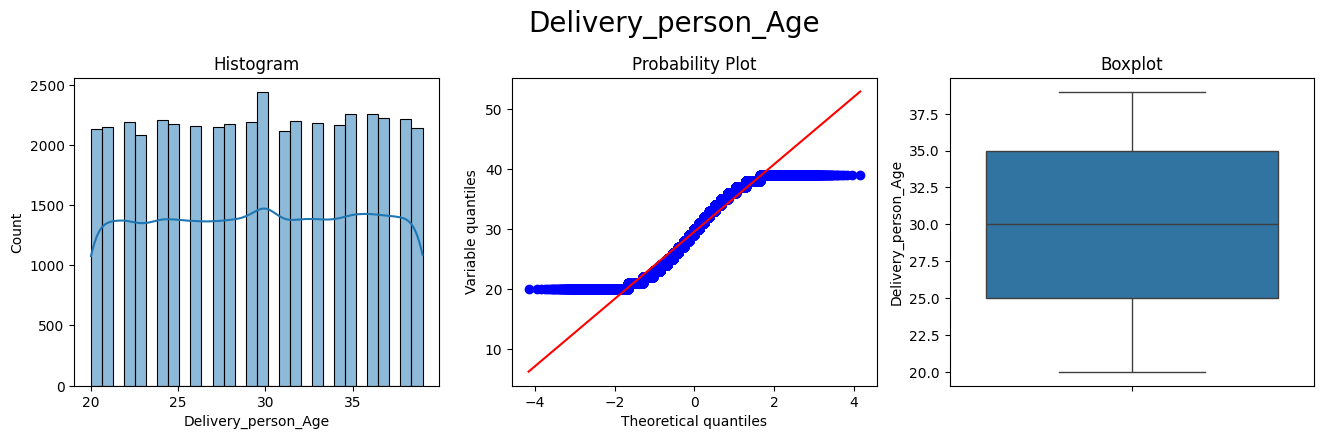

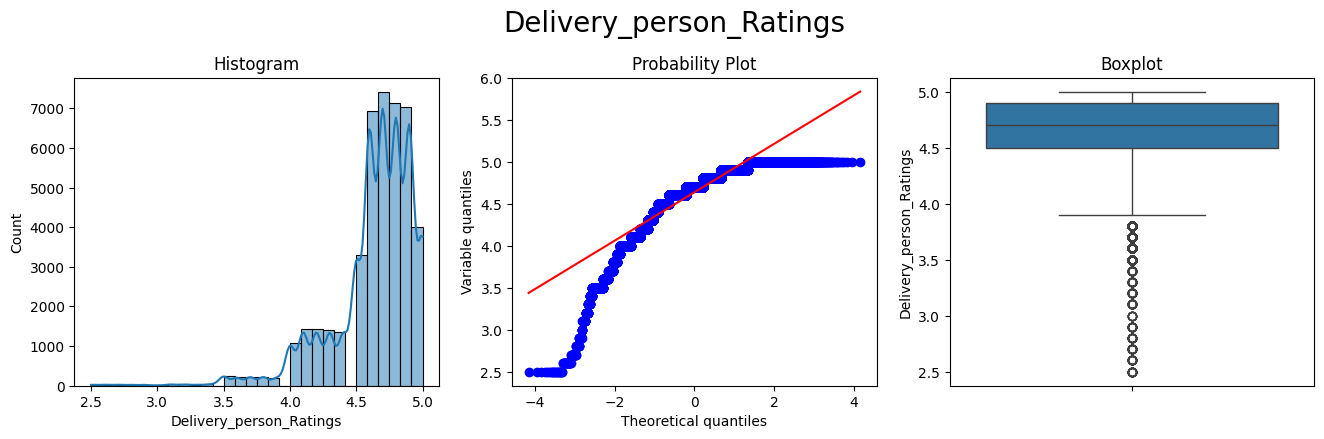

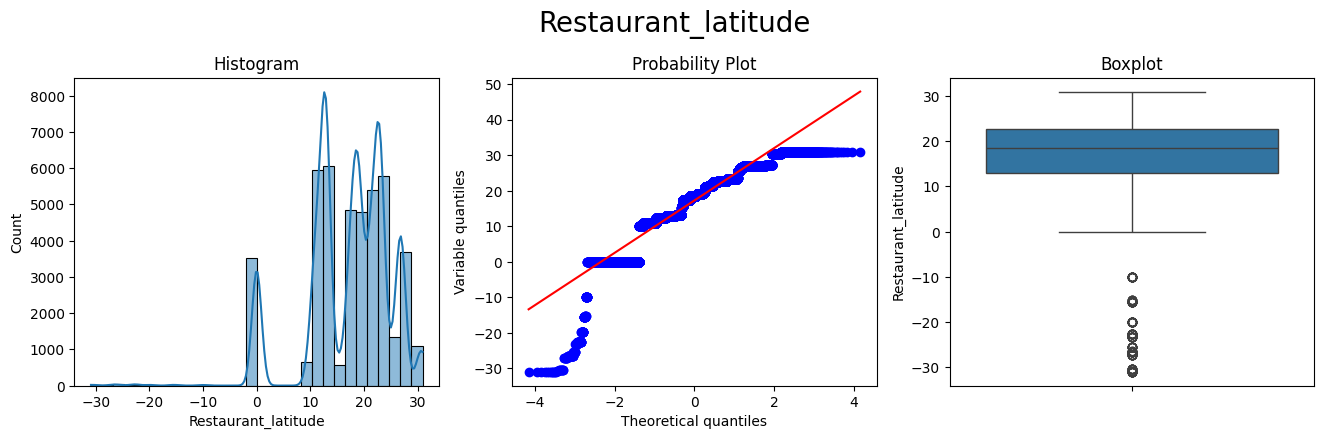

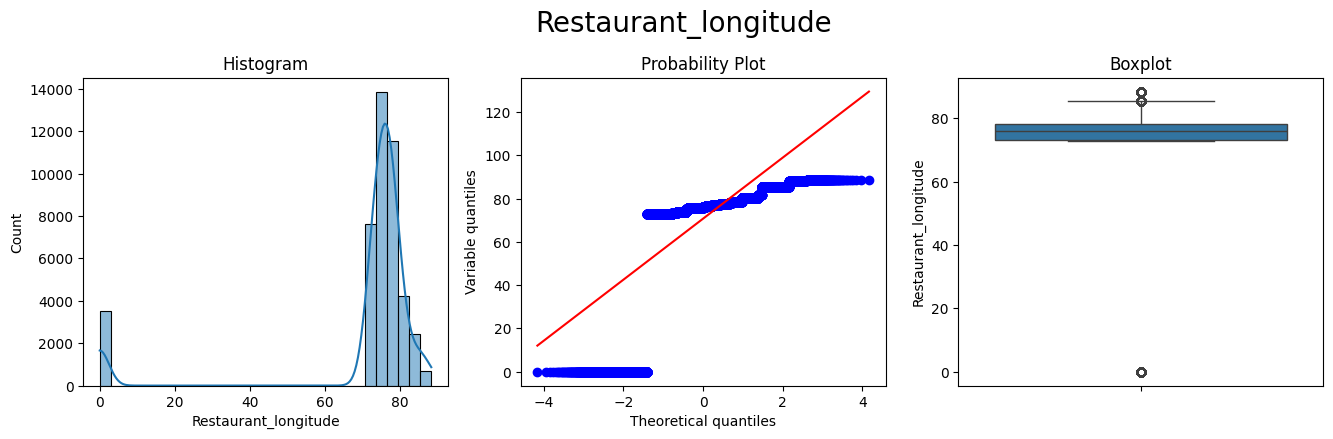

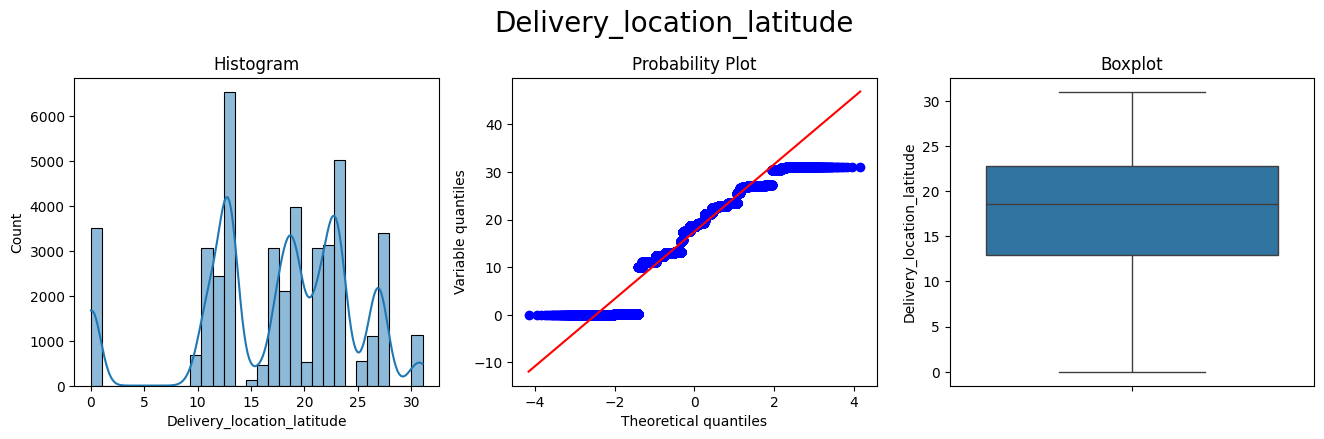

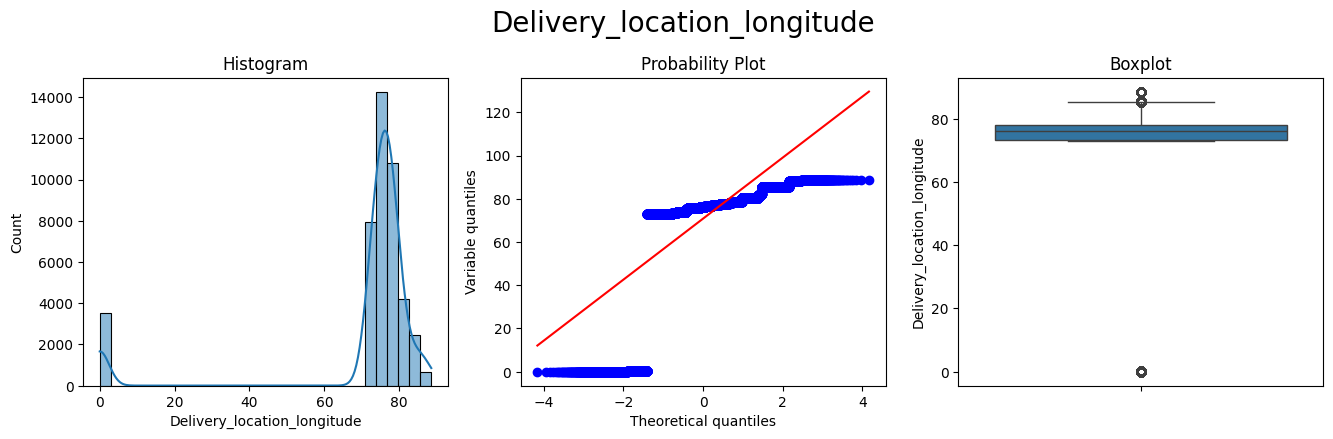

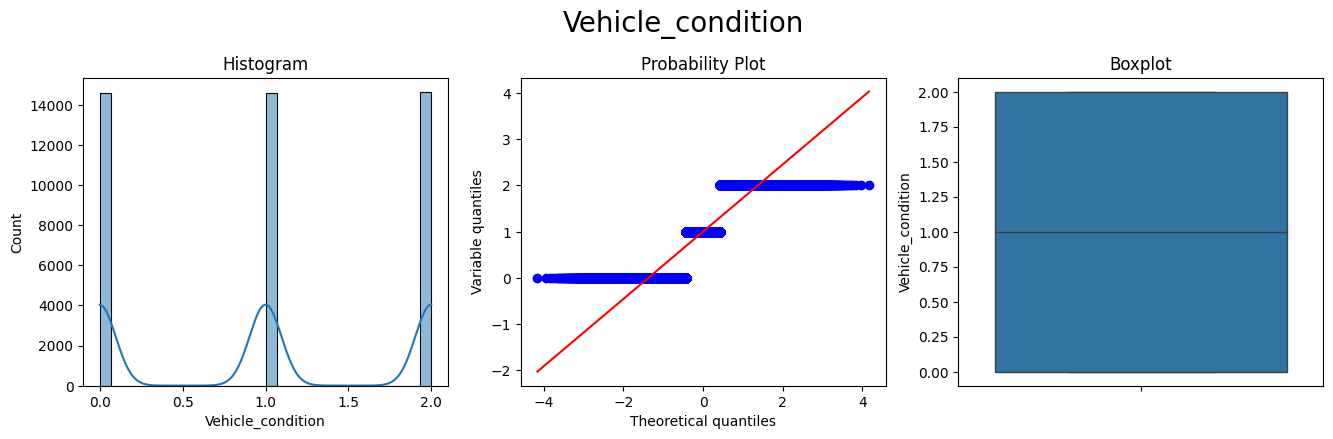

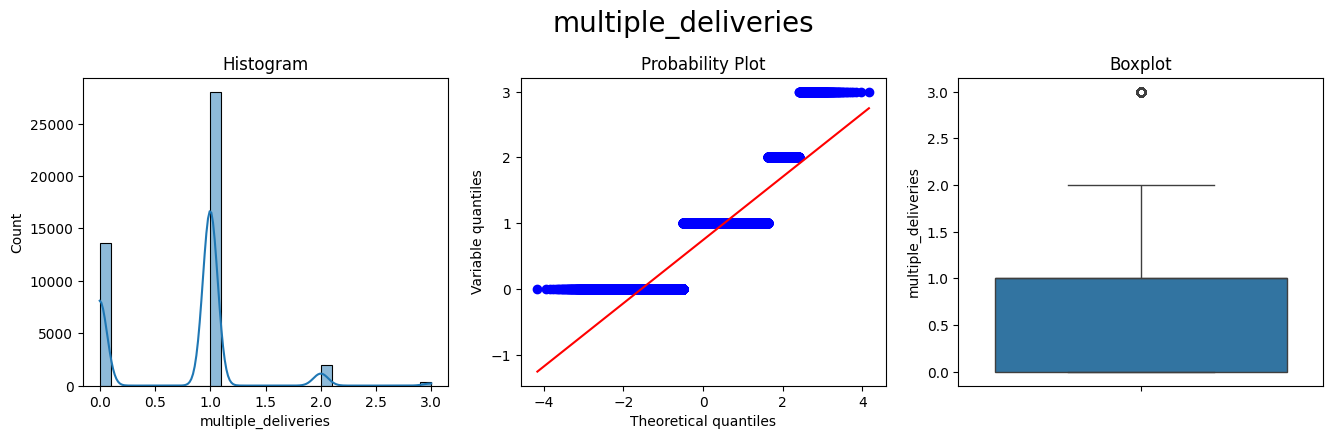

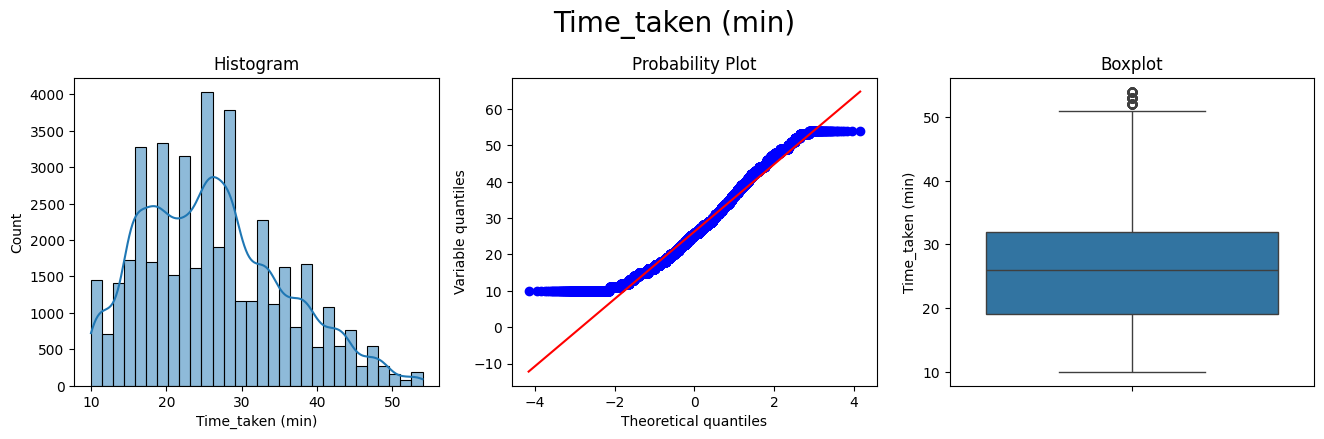

In [ ]:
#Looping for numerical columns
for col in num_cols:
  check_plot(df_zamato,col)
  plt.suptitle(col, fontsize=20, y=1.05)
  plt.show()

In [ ]:
#Sample check for outlier in column Restaurant_latitude and Restaurant_latitude
df_zamato[(df_zamato['Restaurant_latitude'] < 5) | (df_zamato['Restaurant_latitude'] > 40)]

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
24,0x2876,RANCHIRES02DEL01,32.0,3.5,0.0,0.0,0.11,0.11,08-03-2022,21:35,21:45,Stormy,Jam,1,Snack,scooter,0.0,No,Urban,35
43,0xc1ff,AURGRES20DEL03,25.0,5.0,0.0,0.0,0.03,0.03,13-02-2022,22:10,22:25,Cloudy,Low,0,Snack,motorcycle,0.0,No,Metropolitian,15
48,0x8e6c,VADRES02DEL02,39.0,4.2,0.0,0.0,0.08,0.08,02-03-2022,20:35,20:50,Fog,Jam,2,Snack,scooter,1.0,No,Semi-Urban,49
50,0x395b,VADRES04DEL03,36.0,4.7,0.0,0.0,0.06,0.06,13-03-2022,20:15,20:20,Cloudy,Jam,1,Snack,motorcycle,1.0,No,Metropolitian,30
58,0x98aa,VADRES16DEL02,23.0,4.8,0.0,0.0,0.02,0.02,07-03-2022,10:40,10:50,Stormy,Low,1,Meal,scooter,1.0,No,Metropolitian,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45560,0x1de4,VADRES02DEL01,26.0,4.9,0.0,0.0,0.07,0.07,10-03-2022,19:35,19:45,Fog,Jam,1,Drinks,scooter,1.0,No,Metropolitian,32
45567,0x2bed,RANCHIRES02DEL02,34.0,4.2,0.0,0.0,0.13,0.13,04-04-2022,17:25,17:30,Stormy,Medium,0,Drinks,motorcycle,3.0,No,Urban,48
45568,0x373f,VADRES12DEL03,25.0,4.7,0.0,0.0,0.09,0.09,29-03-2022,22:10,22:15,Cloudy,Low,0,Buffet,motorcycle,1.0,No,Metropolitian,21
45570,0xdf1d,BHPRES19DEL02,32.0,4.6,0.0,0.0,0.05,0.05,15-02-2022,18:10,18:20,Stormy,Medium,2,Drinks,scooter,1.0,No,Metropolitian,27


**Intepretation**

Since the focus of this project is delivery optimization, we need to handle the columns that show latitude and longitude. This is because for the Indian region, the latitude values are between 8-35 and the longitude values are between 68-90. Therefore, latitude and longitude values that are not within this range must be deleted because they can disrupt clustering.

In [ ]:
# Valid range for India
lat_min, lat_max = 5, 40
lon_min, lon_max = 60, 100

# Filter rows that have valid coordinate
df_clean = df_zamato[
    (df_zamato['Restaurant_latitude'].between(lat_min, lat_max)) &
    (df_zamato['Restaurant_longitude'].between(lon_min, lon_max)) &
    (df_zamato['Delivery_location_latitude'].between(lat_min, lat_max)) &
    (df_zamato['Delivery_location_longitude'].between(lon_min, lon_max))
]

print("Initial data amount  :", len(df_zamato))
print("Amount of clean data:", len(df_clean))
print("Deleted data     :", len(df_zamato) - len(df_clean))


Initial data amount  : 43853
Amount of clean data: 40188
Deleted data     : 3665


In [ ]:
df_clean.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40188 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           40188 non-null  object 
 1   Delivery_person_ID           40188 non-null  object 
 2   Delivery_person_Age          40188 non-null  float64
 3   Delivery_person_Ratings      40188 non-null  float64
 4   Restaurant_latitude          40188 non-null  float64
 5   Restaurant_longitude         40188 non-null  float64
 6   Delivery_location_latitude   40188 non-null  float64
 7   Delivery_location_longitude  40188 non-null  float64
 8   Order_Date                   40188 non-null  object 
 9   Time_Orderd                  40188 non-null  object 
 10  Time_Order_picked            40188 non-null  object 
 11  Weather_conditions           40188 non-null  object 
 12  Road_traffic_density         40188 non-null  object 
 13  Vehicle_condition    

In [ ]:
num_cols_clean = df_clean.select_dtypes(include=['int64', 'float64']).columns

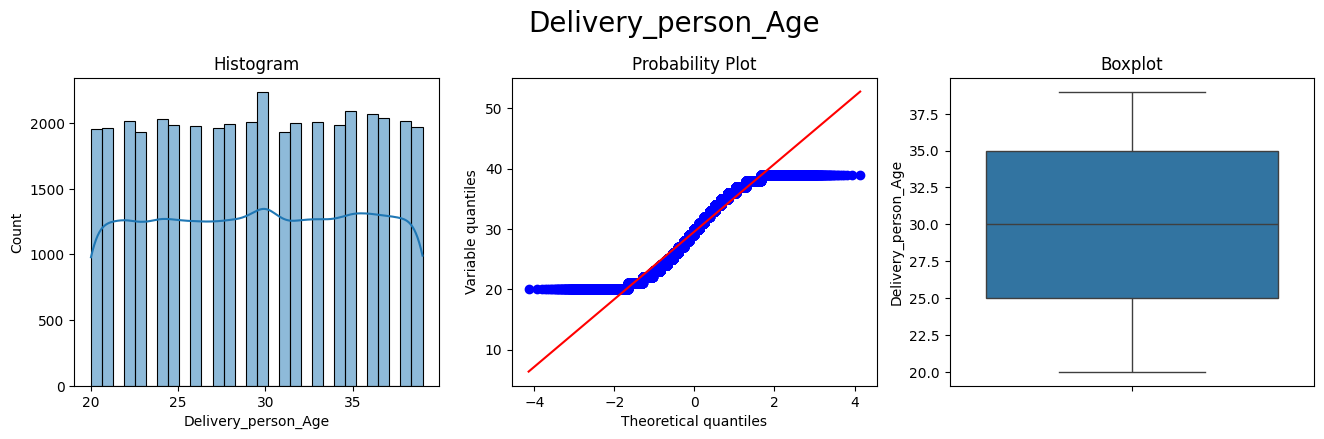

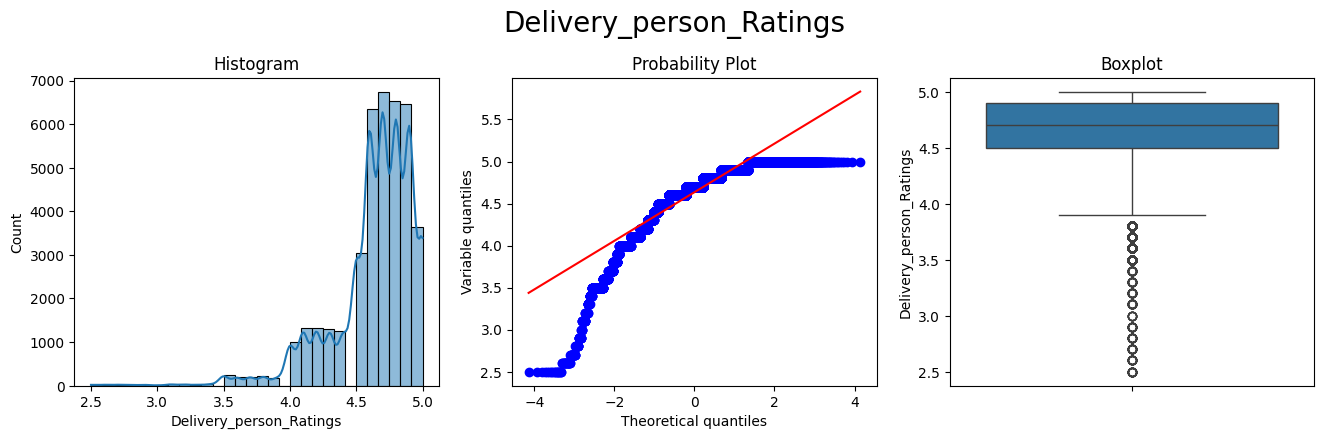

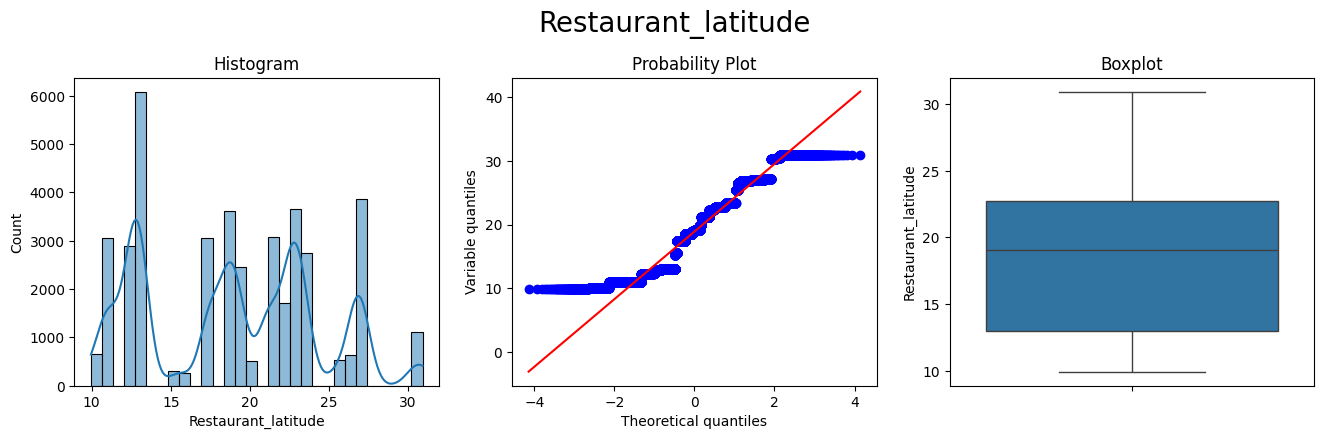

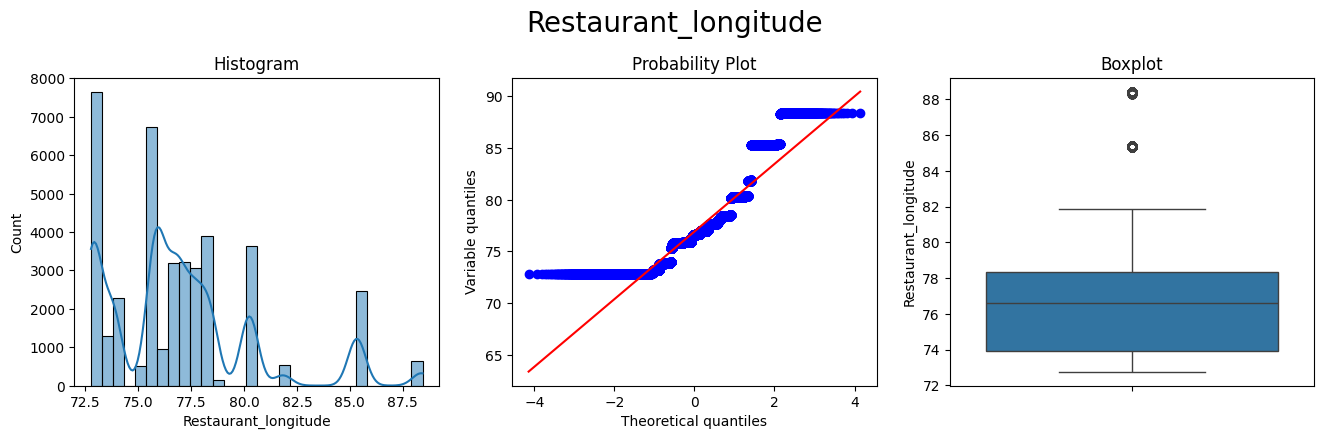

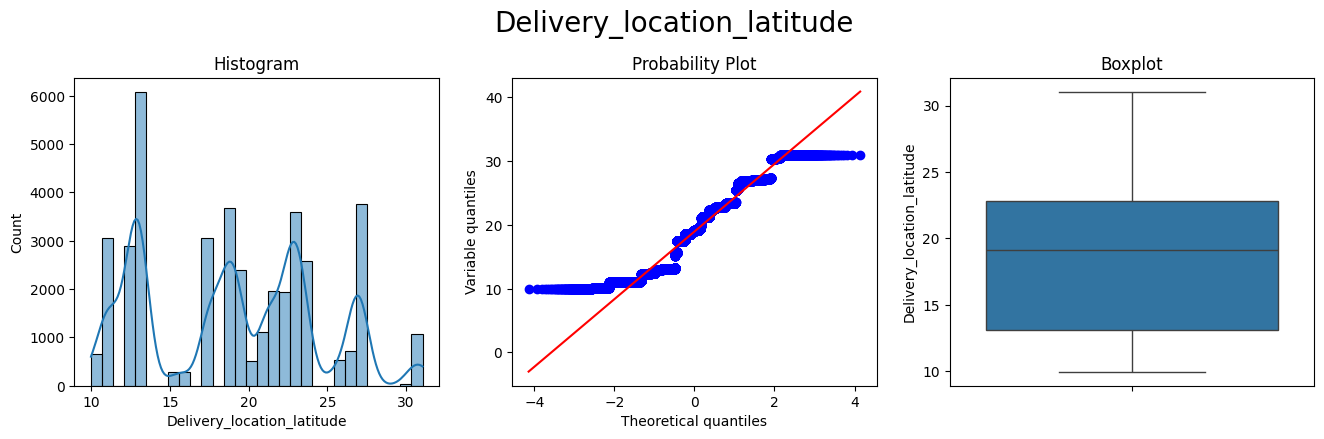

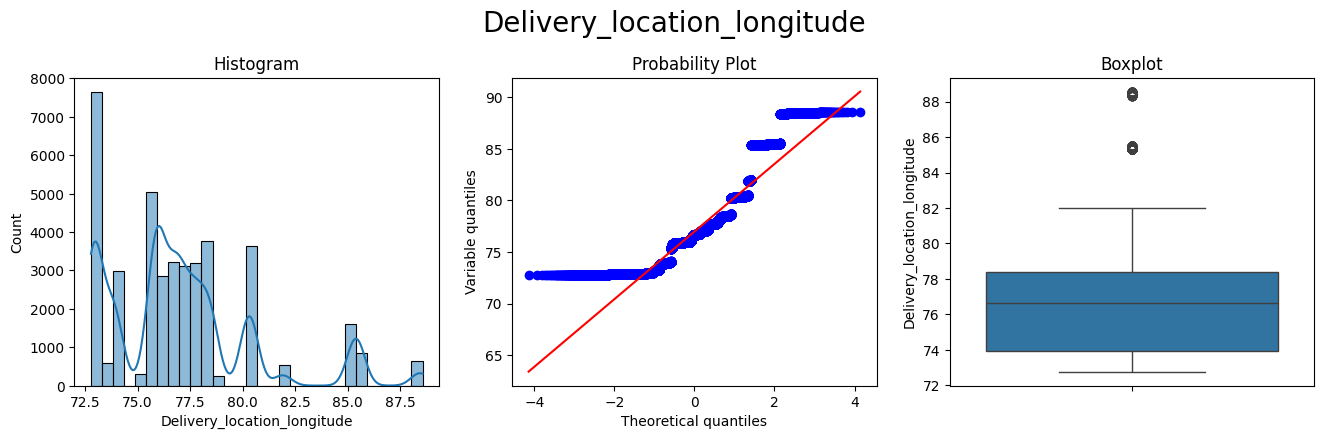

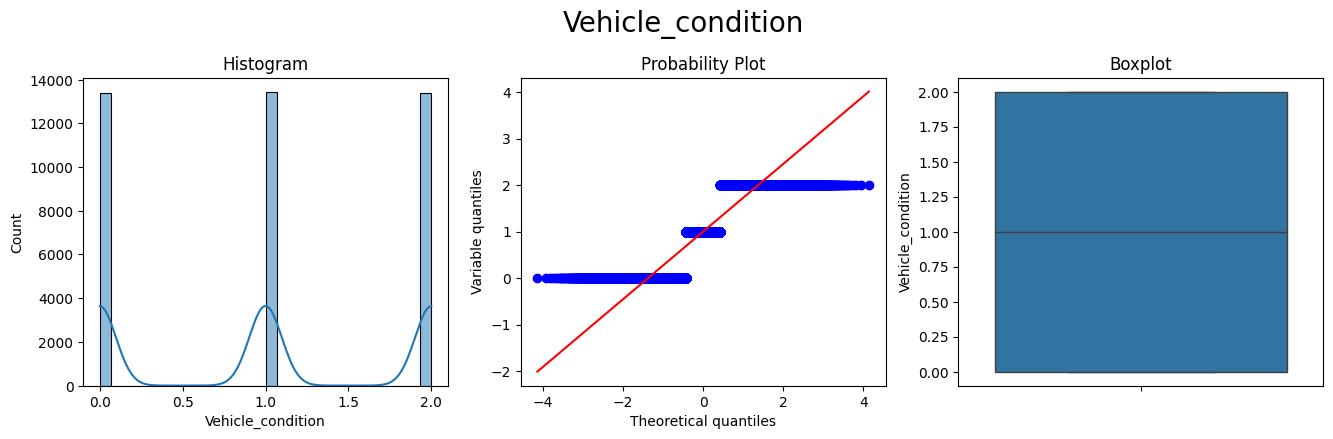

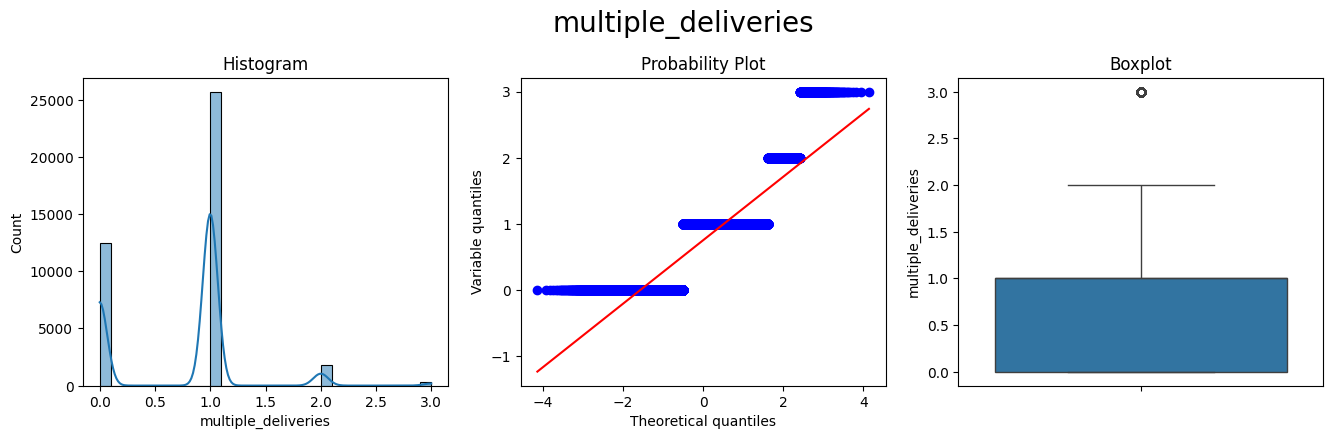

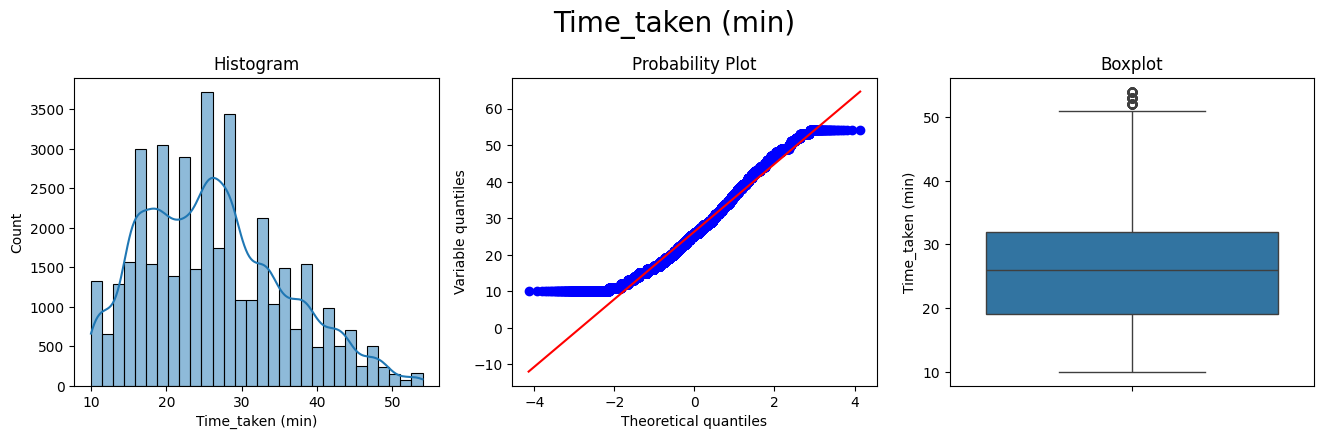

In [ ]:
#Rechecking plot after handling outlier
for col in num_cols_clean:
  check_plot(df_clean,col)
  plt.suptitle(col, fontsize=20, y=1.05)
  plt.show()

**Intepretation**

For outliers in the columns `Delivery_person_Ratings`, `multiple_deliveries`, and `Time_taken (min)`, it still makes sense.

### 4. Changing Data Types

In [ ]:
#Changing 'Order_Date' into Date Time
df_clean['Order_Date'] = pd.to_datetime(df_clean['Order_Date'], format='%d-%m-%Y')

/tmp/ipython-input-2972173198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Order_Date'] = pd.to_datetime(df_clean['Order_Date'], format='%d-%m-%Y')


In [ ]:
# Convert Time_Orderd (string "HH:MM") to datetime time
df_clean["Time_Orderd"] = pd.to_datetime(df_clean["Time_Orderd"], format="%H:%M", errors='coerce')

/tmp/ipython-input-413954080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Time_Orderd"] = pd.to_datetime(df_clean["Time_Orderd"], format="%H:%M", errors='coerce')


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40188 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           40188 non-null  object        
 1   Delivery_person_ID           40188 non-null  object        
 2   Delivery_person_Age          40188 non-null  float64       
 3   Delivery_person_Ratings      40188 non-null  float64       
 4   Restaurant_latitude          40188 non-null  float64       
 5   Restaurant_longitude         40188 non-null  float64       
 6   Delivery_location_latitude   40188 non-null  float64       
 7   Delivery_location_longitude  40188 non-null  float64       
 8   Order_Date                   40188 non-null  datetime64[ns]
 9   Time_Orderd                  36474 non-null  datetime64[ns]
 10  Time_Order_picked            40188 non-null  object        
 11  Weather_conditions           40188 non-null  o

In [ ]:
df_clean.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,1900-01-01 21:55:00,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,2022-02-13,1900-01-01 14:55:00,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,2022-03-04,1900-01-01 17:30:00,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,2022-02-13,1900-01-01 09:20:00,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,2022-02-14,1900-01-01 19:50:00,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


In [ ]:
#Save to make dashboard
df_clean.to_csv('df_clean.csv', index=False)

## Exploratory Data Analysis

1. Geospatial Distribution Analysis
* Scatter Plot Customer Locations > To see the raw distribution pattern of delivery points
* Scatter Plot Restaurant vs Customer > Assess the average distance
* Density Map / Heatmap > Determine the most densely populated areas
2. Distance Analysis (Restaurant → Customer)
* Distribution of Delivery Distance
* Distance vs Delivery Time
* Outlier Distance Inspection
3. Delivery Time & Delay Analysis
* Distribution of Time Taken > Determines “slow” vs. “normal” categories
* Time Taken by City > Are there cities that need more clusters
* Time Taken by Traffic Level > Supports workload analysis per cluster
* Time Taken by Weather > Understand risks per zone
4. Traffic & Weather Pattern Analysis
* Road Traffic Density Distribution > Does a certain area have high traffic?
* Weather Conditions Distribution > Used for cluster labeling
5. Delivery Demand Pattern (Workload Analysis)
* Number of Orders per City
* Number of Orders per Hour / Time of Day > Determine busy zones
* Multiple Deliveries Pattern > Impact on driver workload





### 1. Geospatial Distribution Analysis

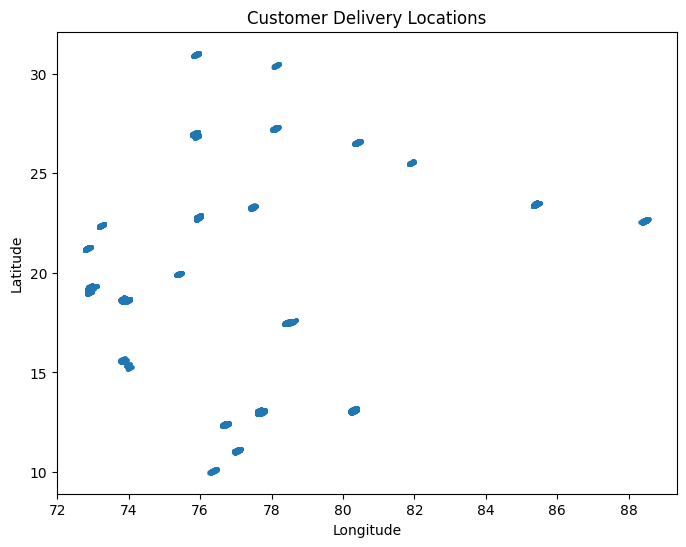

In [ ]:
# Scatter Plot Customer Locations
plt.figure(figsize=(8,6))
plt.scatter(
    df_clean['Delivery_location_longitude'],
    df_clean['Delivery_location_latitude'],
    s=5, alpha=0.4
)
plt.title("Customer Delivery Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


**Intepretasi**

The scatter plot shows the distribution of customer locations based on longitude and latitude coordinates, where the points are spread out widely enough to illustrate a fairly large service area. Several clusters of customers are concentrated in certain areas—mainly around longitude 73–76 and latitude 18–22—while some points appear further from the center of distribution and can be considered relatively isolated locations. This pattern indicates that most demand comes from certain areas, but there are still customers in more remote locations who may affect delivery times and efficiency.

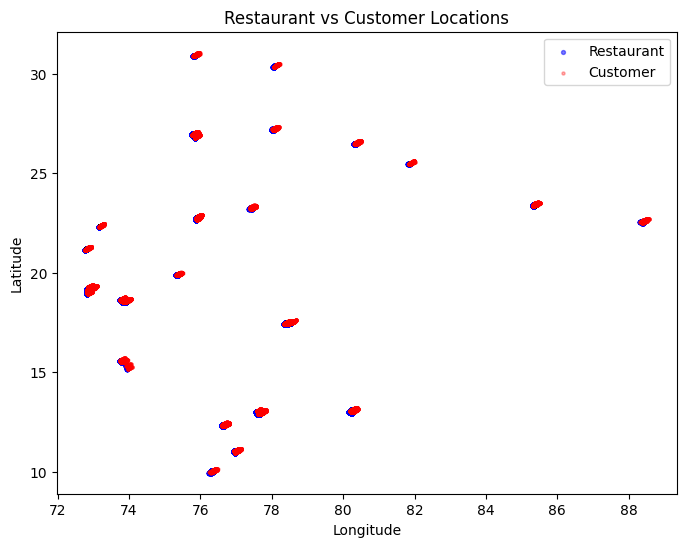

In [ ]:
# Scatter Plot Restaurant vs Customer
plt.figure(figsize=(8,6))

plt.scatter(df_clean['Restaurant_longitude'], df_clean['Restaurant_latitude'],
            s=8, alpha=0.5, label="Restaurant", color="blue")

plt.scatter(df_clean['Delivery_location_longitude'], df_clean['Delivery_location_latitude'],
            s=5, alpha=0.3, label="Customer", color="red")

plt.title("Restaurant vs Customer Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


**Intepretation**

The plot shows a comparison of the locations of restaurants (blue) and customers (red), which appear to be very close to each other at every point. This indicates that the locations of restaurants and delivery destinations in the dataset are almost always at the same coordinates or very close to each other, so delivery distances tend to be short and concentrated in certain areas. This pattern also indicates that there is no significant difference between the distribution of restaurants and customers, making the delivery process relatively efficient and eliminating any extreme locations far from the center of activity.

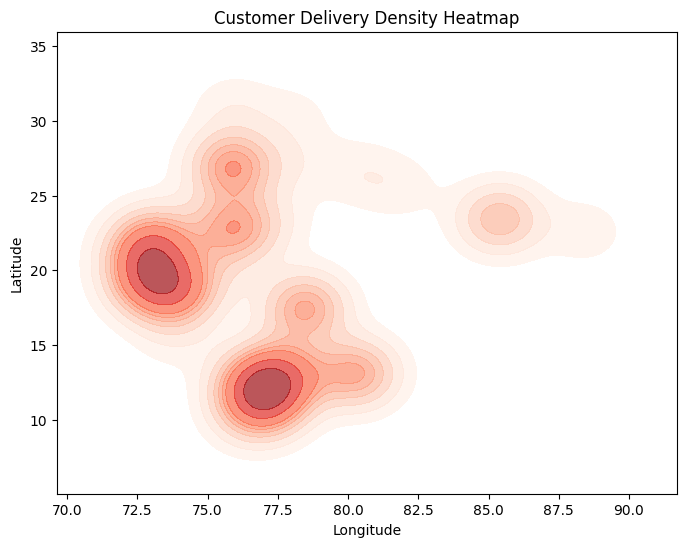

In [ ]:
# Density Map / Heatmap > Determine the most densely populated areas
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=df_clean['Delivery_location_longitude'],
    y=df_clean['Delivery_location_latitude'],
    cmap="Reds", fill=True, bw_method=0.3, alpha=0.7
)
plt.title("Customer Delivery Density Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


**Intepretation**

The image shows a heat map of customer delivery density, where the dark red areas indicate the highest concentration of deliveries. The visualization shows that the largest density cluster is located at a longitude of approximately 72–76 and a latitude of 18–22, indicating that this area is the center of the most intense delivery activity. In addition, there are several medium-density clusters around longitude 75–78 and latitude 24–28, as well as other small clusters around longitude 84–87. Overall, this map helps identify geographic areas with the highest demand.

### 2. Distance Analysis (Restaurant → Customer)

In [ ]:
#Define Haversine Distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in KM
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [ ]:
#Measure the distance
df_clean["distance_km"] = haversine(
    df_clean["Restaurant_latitude"],
    df_clean["Restaurant_longitude"],
    df_clean["Delivery_location_latitude"],
    df_clean["Delivery_location_longitude"]
)

/tmp/ipython-input-2707427406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["distance_km"] = haversine(


In [ ]:
df_clean.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),distance_km
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,1900-01-01 21:55:00,...,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46,10.280582
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,2022-02-13,1900-01-01 14:55:00,...,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23,6.242319
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,2022-03-04,1900-01-01 17:30:00,...,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21,13.787860
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,2022-02-13,1900-01-01 09:20:00,...,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20,2.930258
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,2022-02-14,1900-01-01 19:50:00,...,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41,19.396618


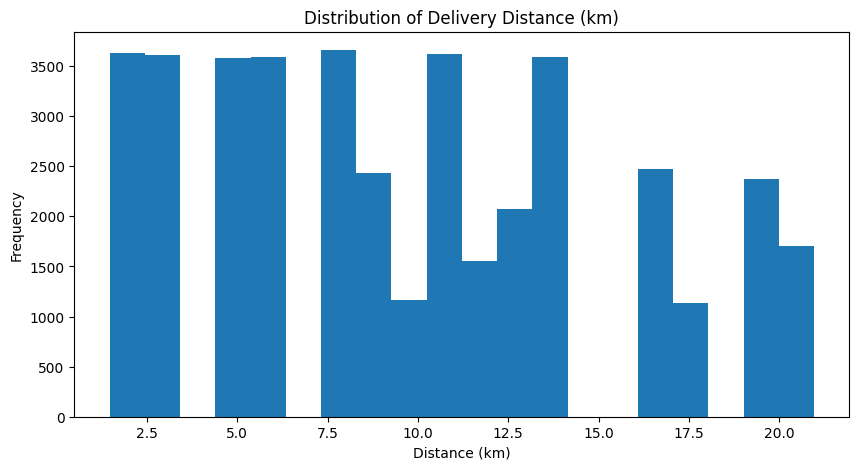

In [ ]:
# Distribution of Delivery Distance
plt.figure(figsize=(10,5))
plt.hist(df_clean["distance_km"], bins=20)
plt.title("Distribution of Delivery Distance (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

**Intepretation**

The histogram shows a fairly spread distribution of delivery distances, ranging from around 2 km to more than 20 km, with most deliveries falling within the 5–15 km range.

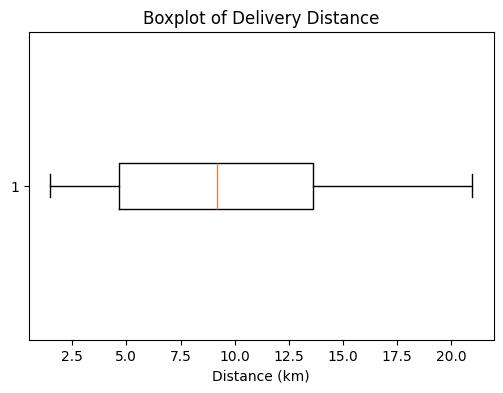

In [ ]:
# Boxplot for checking outlier
plt.figure(figsize=(6,4))
plt.boxplot(df_clean["distance_km"], vert=False)
plt.title("Boxplot of Delivery Distance")
plt.xlabel("Distance (km)")
plt.show()

Intepretation

The boxplot below confirms that the data is quite varied but does not have any extreme outliers, as the whiskers are still within a reasonable range.

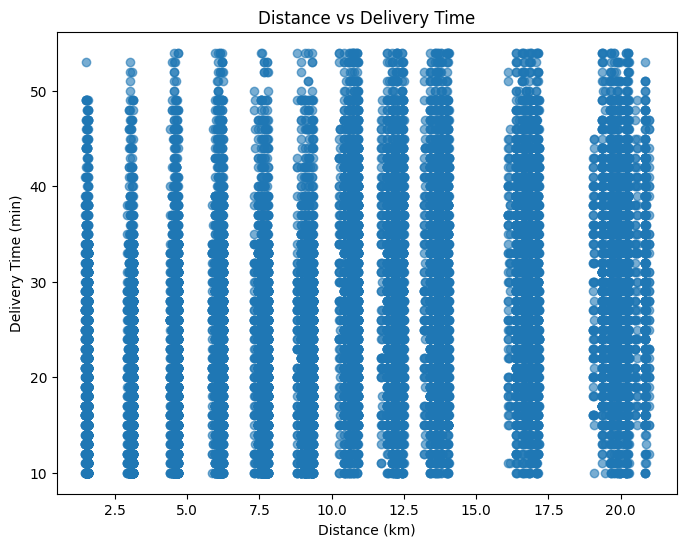

In [ ]:
# Distance vs Delivery Time
plt.figure(figsize=(8,6))
plt.scatter(df_clean["distance_km"], df_clean["Time_taken (min)"], alpha=0.6)
plt.title("Distance vs Delivery Time")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (min)")
plt.show()

**Interpretation**

The scatter plot shows the relationship between delivery distance and delivery time, where it generally appears that the greater the distance, the greater the variation in delivery time, but there is no strong linear pattern. The data points are scattered quite widely in each distance category, indicating that delivery time is influenced not only by distance but also by other factors such as traffic conditions, routes, or courier efficiency. Although there is a slight tendency for delivery time to increase with greater distance, the spread remains high, so the relationship between the variables can be said to be weak and inconsistent.

In [ ]:
# OUTLIER DISTANCE INSPECTION
q1 = df_clean["distance_km"].quantile(0.25)
q3 = df_clean["distance_km"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df_clean[df_clean["distance_km"] > upper_bound]

print("Jumlah outlier distance:", len(outliers))
print("Outlier example:")
print(outliers[["Restaurant_latitude","Restaurant_longitude",
                "Delivery_location_latitude","Delivery_location_longitude",
                "distance_km"]].head())

Jumlah outlier distance: 0
Outlier example:
Empty DataFrame
Columns: [Restaurant_latitude, Restaurant_longitude, Delivery_location_latitude, Delivery_location_longitude, distance_km]
Index: []


**Interpretation**

There is no outlier in distance

### 3. Delivery Time & Delay Analysis

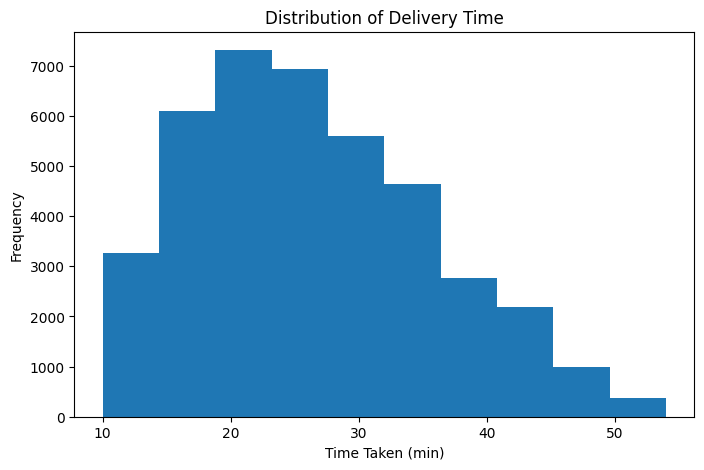

In [ ]:
# Distribution of Time Taken
plt.figure(figsize=(8,5))
plt.hist(df_clean["Time_taken (min)"], bins=10)
plt.title("Distribution of Delivery Time")
plt.xlabel("Time Taken (min)")
plt.ylabel("Frequency")
plt.show()

**Intepretation**

The histogram shows the distribution of time taken for delivery. The range of time taken is between 10 and 60 minutes, with the majority of deliveries taking between 15 and 30 minutes.

In [ ]:
time_by_city = df_clean.groupby("City")["Time_taken (min)"].value_counts()
time_by_city

City           Time_taken (min)
Metropolitian  26                  1530
               25                  1487
               27                  1452
               29                  1414
               28                  1374
                                   ... 
Urban          50                    10
               53                     8
               51                     7
               54                     7
               52                     3
Name: count, Length: 101, dtype: int64

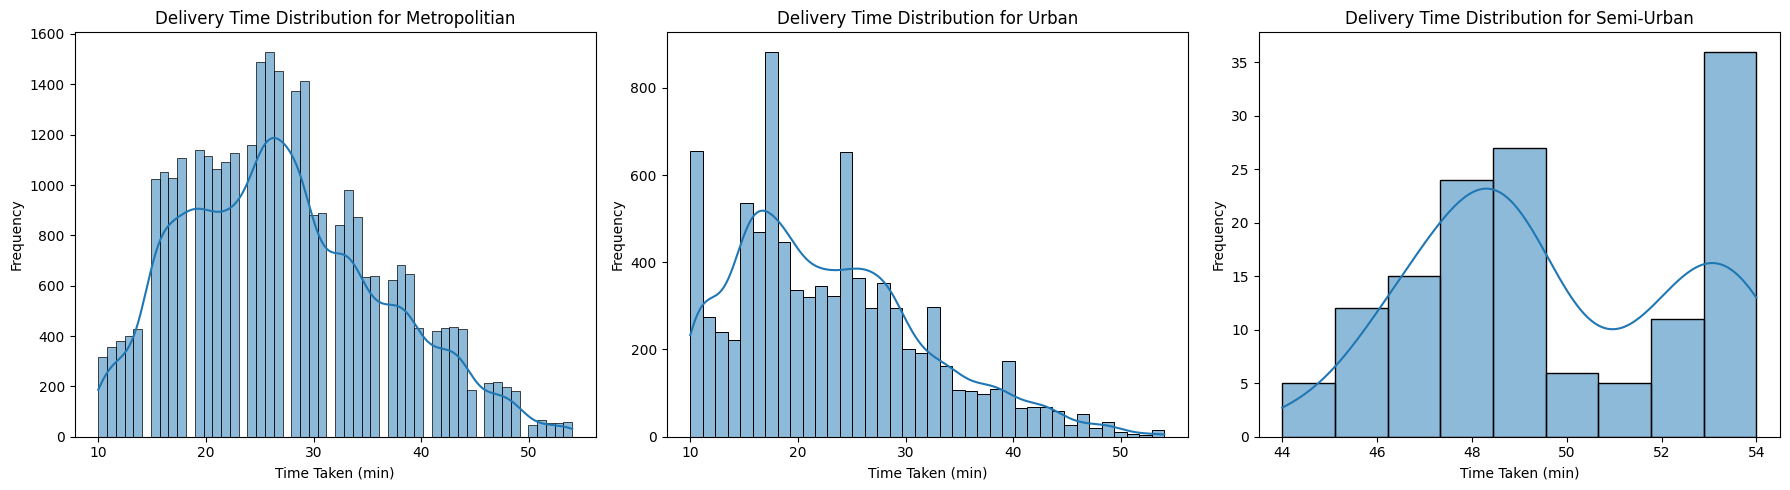

In [ ]:
#Get cities
cities = df_clean["City"].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Looping
for ax, city_name in zip(axes, cities):
    city_data = df_clean[df_clean["City"] == city_name]
    sns.histplot(data=city_data, x="Time_taken (min)", kde=True, ax=ax)
    ax.set_title(f"Delivery Time Distribution for {city_name}")
    ax.set_xlabel("Time Taken (min)")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

**Intepretation**

1. Metropolitan

The distribution of delivery times in metropolitan areas is the largest and most varied. The histogram shows a pattern that tends to approach a normal distribution with a peak (mode) of around 25–30 minutes, indicating that most deliveries are completed within that range. There is a fairly wide spread from 10 to 50 minutes, but most of the data is concentrated around 20–35 minutes. This shows that metropolitan areas have high volumes but relatively stable delivery processes, although there is still variation due to traffic congestion or the dynamics of large cities.

2. Urban

The distribution in urban areas appears more right-skewed, with many deliveries completed faster, around 10–20 minutes. However, there is a long tail towards 40–50 minutes, indicating that some deliveries take longer than the majority. In general, delivery times in urban areas are faster than in metropolitan areas, but the variation is also quite high, indicating that some routes are fast and others are slower.

3. Semi-Urban

Semi-Urban areas have a very different distribution due to the small amount of data. The time range is narrower, around 44–54 minutes, with most deliveries occurring in the 48–52 minute range. There is no significant variation, and there are no extreme low values. This indicates that deliveries in Semi-Urban areas tend to be slower but more consistent, likely due to the greater distance between areas and relatively stable routes without the complex traffic congestion found in large cities.

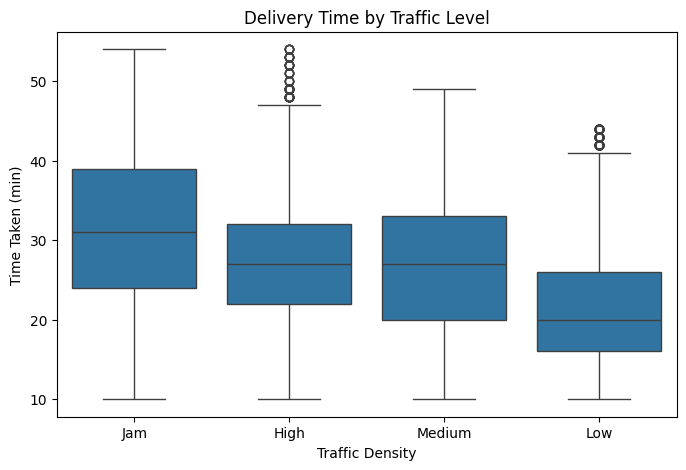


Average Time Taken by Traffic Level:
Road_traffic_density
High      27.188069
Jam       31.164970
Low       21.289692
Medium    26.750536
Name: Time_taken (min), dtype: float64


In [ ]:
#Time taken by traffic density
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x="Road_traffic_density", y="Time_taken (min)")
plt.title("Delivery Time by Traffic Level")
plt.xlabel("Traffic Density")
plt.ylabel("Time Taken (min)")
plt.show()

print("\nAverage Time Taken by Traffic Level:")
print(df_clean.groupby("Road_traffic_density")["Time_taken (min)"].mean())

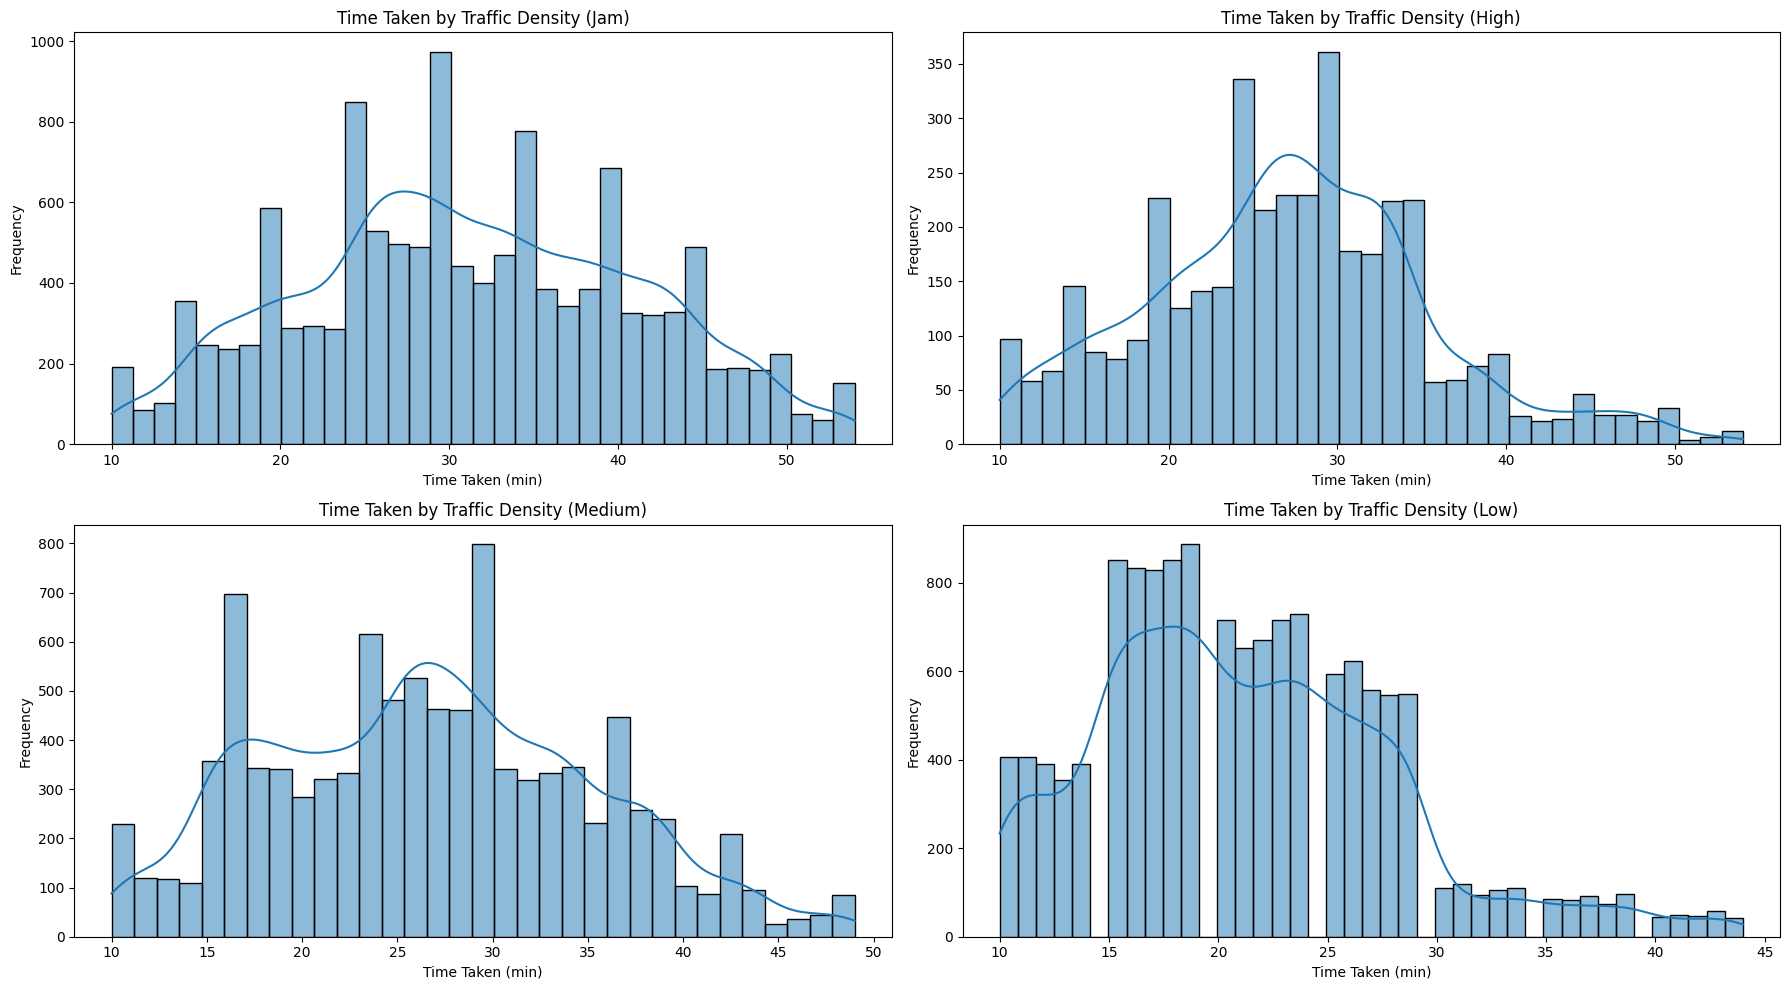

In [ ]:
#Get cities
traffic_density = df_clean["Road_traffic_density"].unique()

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

#Looping
for ax, traffic_dens in zip(axes.flatten(), traffic_density):
    traffic = df_clean[df_clean["Road_traffic_density"] == traffic_dens]
    sns.histplot(data=traffic, x="Time_taken (min)", kde=True, ax=ax)
    ax.set_title(f"Time Taken by Traffic Density ({traffic_dens})")
    ax.set_xlabel("Time Taken (min)")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

**Intepretation**

1. Time Taken by Traffic Density (Jam):

    The distribution of time taken during congestion (hours) shows a wide range, but peaks at around 25 to 35 minutes. The highest frequency reaches more than 800 trips. The density curve (KDE) shows a shape that approximates a normal distribution but is slightly skewed to the right (positively skewed), with a tail extending to around 55 minutes. This indicates that although most trips take between 20 and 45 minutes, travel times can vary significantly and often exceed 30 minutes.

2. Time Taken by Traffic Density (High):

    For high traffic density, the distribution is more centralized and less varied than during total congestion. The main peak (mode) is around 25 to 30 minutes, with a frequency of over 350 trips. Although the peak is similar to Rush Hour conditions, the overall travel time range is shorter, with most trips completed within 20 to 40 minutes. The shape of the KDE curve also shows a clear tendency to center around these values.

3. Time Taken by Traffic Density (Medium):

    When traffic density is moderate, the distribution becomes more symmetrical with a peak around 25 to 30 minutes. The highest frequency is slightly above 600 trips. The KDE curve appears smooth and strongly centered around 20 to 35 minutes. This indicates that under medium traffic conditions, travel times are relatively predictable, rarely exceeding 40 minutes, and extreme travel times (very short or very long) are less frequent.

4. Time Taken by Traffic Density (Low):

    Low traffic conditions show the fastest and most concentrated travel time distribution, with a clear peak (mode) shifted to the left (shorter times), around 15 to 25 minutes. The highest frequency reaches more than 700 trips. This distribution shows that almost all trips are completed in less than 35 minutes, and the largest concentration occurs between 15 and 25 minutes, reflecting fast and stable travel times without significant traffic congestion.

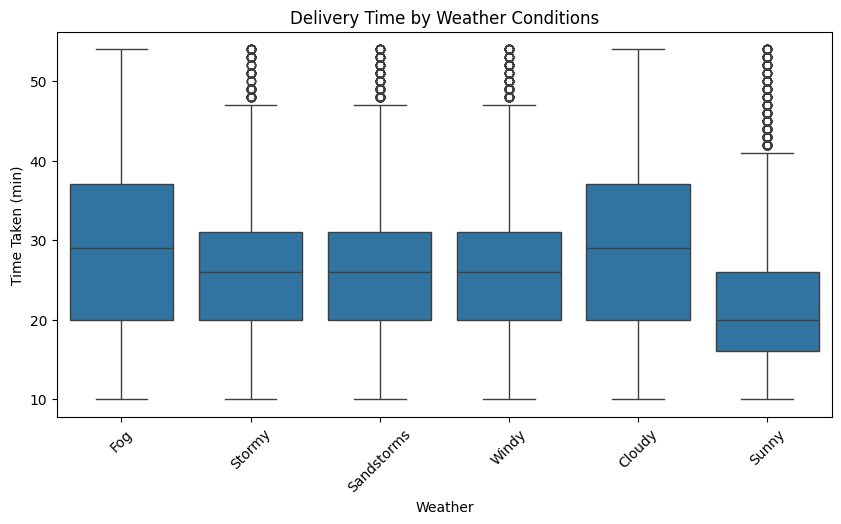

In [ ]:
#Time taken by weather conditions
plt.figure(figsize=(10,5))
sns.boxplot(data=df_clean, x="Weather_conditions", y="Time_taken (min)")
plt.title("Delivery Time by Weather Conditions")
plt.xlabel("Weather")
plt.ylabel("Time Taken (min)")
plt.xticks(rotation=45)
plt.show()

**Intepretation**

**Longest Delivery Time (Highest Median)**: Foggy and cloudy conditions show the longest median delivery time, which is around 30-35 minutes. This indicates that foggy and cloudy conditions tend to slow down delivery speeds the most.

**Fastest Delivery Time (Lowest Median)**: Sunny conditions have the fastest median delivery time, which is under 20 minutes (around 18 minutes). The box (IQR) for these conditions is also the narrowest, indicating the most consistent and fastest delivery times.

**Variability & Outliers**: Stormy, Sandstorms, and Windy conditions have similar medians (around 25-30 minutes). However, all non-Clear weather conditions (Fog, Stormy, Sandstorms, Windy, Cloudy) show outliers (marked with circles) above the upper limit. These outliers indicate that, despite varying medians, all adverse weather conditions can cause extreme delays exceeding 50 minutes.

### 4. Traffic & Weather Pattern Analysis

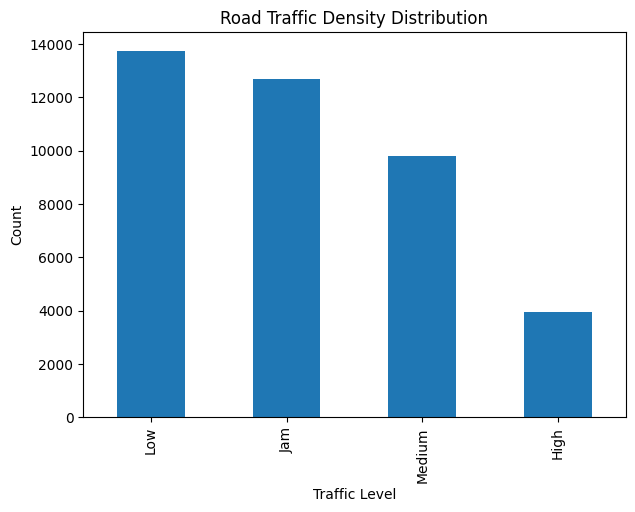

In [ ]:
#Road traffic Density Distribution
plt.figure(figsize=(7,5))
df_clean["Road_traffic_density"].value_counts().plot(kind='bar')
plt.title("Road Traffic Density Distribution")
plt.xlabel("Traffic Level")
plt.ylabel("Count")
plt.show()


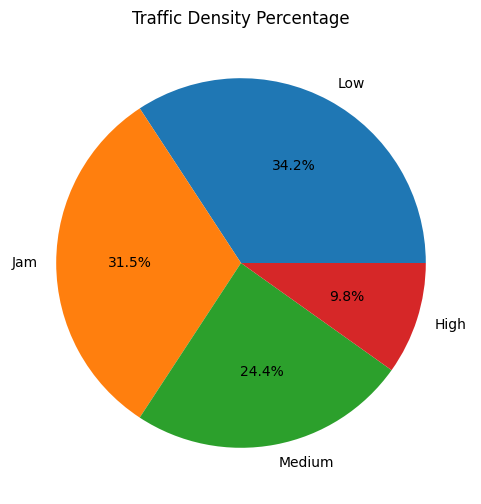

In [ ]:
# Pie chart percentage
plt.figure(figsize=(6,6))
df_clean["Road_traffic_density"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Traffic Density Percentage")
plt.ylabel("")
plt.show()

**Interpretation**

**Most Frequent (Highest Frequency)**: Low traffic density is the most frequently recorded, with more than 11,000 incidents (approximately 34.1% of the total data).

**Least Frequent (Lowest Frequency)**: High traffic density is the least frequently recorded, with fewer than 4,000 incidents (only 9.8% of the total data).

Other Conditions: Congestion (Jam) ranks second with just over 10,000 incidents (approximately 31.6%), followed by Medium conditions with approximately 8,000 incidents (approximately 24.5%).

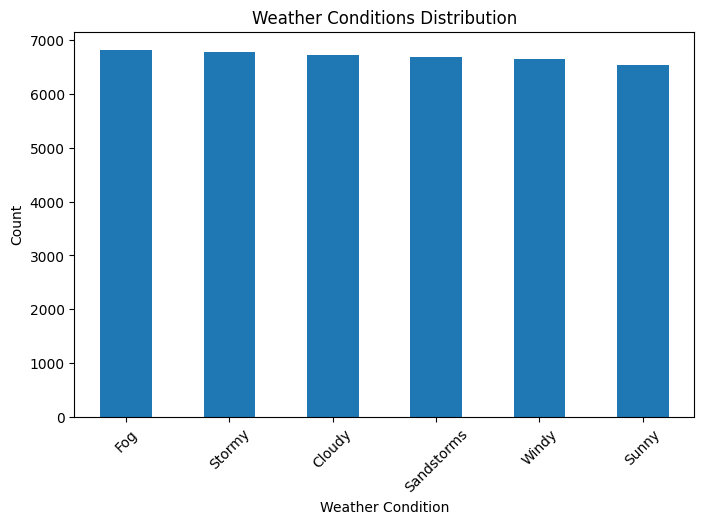

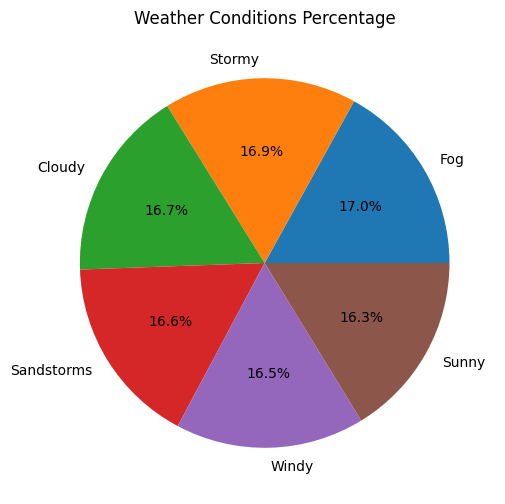

In [ ]:
#Weather condition distributions
plt.figure(figsize=(8,5))
df_clean["Weather_conditions"].value_counts().plot(kind='bar')
plt.title("Weather Conditions Distribution")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Pie chart percentage
plt.figure(figsize=(6,6))
df_clean["Weather_conditions"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Weather Conditions Percentage")
plt.ylabel("")
plt.show()

Interpretation

A very balanced number of observations for each weather condition. This means that the analysis of delivery times based on weather will not be biased due to the dominance of a particular weather condition in the dataset.

### 5. Delivery Demand Pattern (Workload Analysis)

In [ ]:
# Extract hour for time analysis
df_clean["Order_Hour"] = df_clean["Time_Orderd"].dt.hour

/tmp/ipython-input-3376302993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Order_Hour"] = df_clean["Time_Orderd"].dt.hour


In [ ]:
df_clean.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),distance_km,Order_Hour
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,1900-01-01 21:55:00,...,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46,10.280582,21.0
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,2022-02-13,1900-01-01 14:55:00,...,High,1,Meal,motorcycle,1.0,No,Metropolitian,23,6.242319,14.0
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,2022-03-04,1900-01-01 17:30:00,...,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21,13.787860,17.0
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,2022-02-13,1900-01-01 09:20:00,...,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20,2.930258,9.0
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,2022-02-14,1900-01-01 19:50:00,...,Jam,1,Snack,scooter,1.0,No,Metropolitian,41,19.396618,19.0


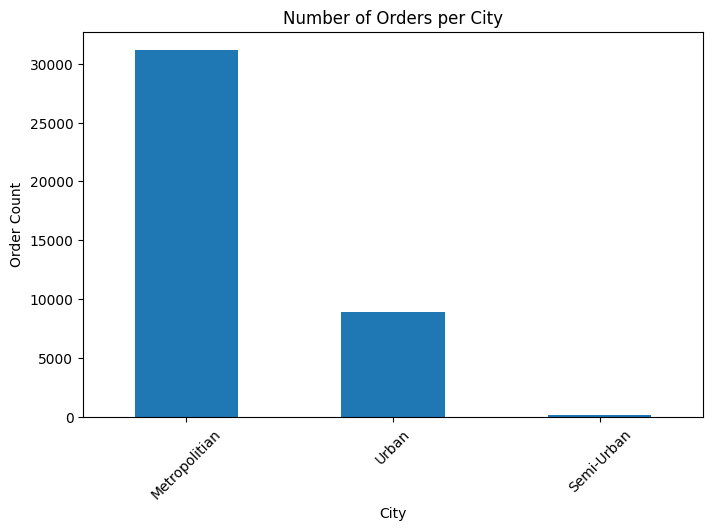

In [ ]:
#Number of orders per city
plt.figure(figsize=(8,5))
df_clean["City"].value_counts().plot(kind='bar')
plt.title("Number of Orders per City")
plt.xlabel("City")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.show()


**Interpretation**

Most orders come from metropolitan areas, with the number of orders reaching more than 25,000 (approximately 25,500). This shows that delivery operations are heavily dominated by demand from metropolitan areas.

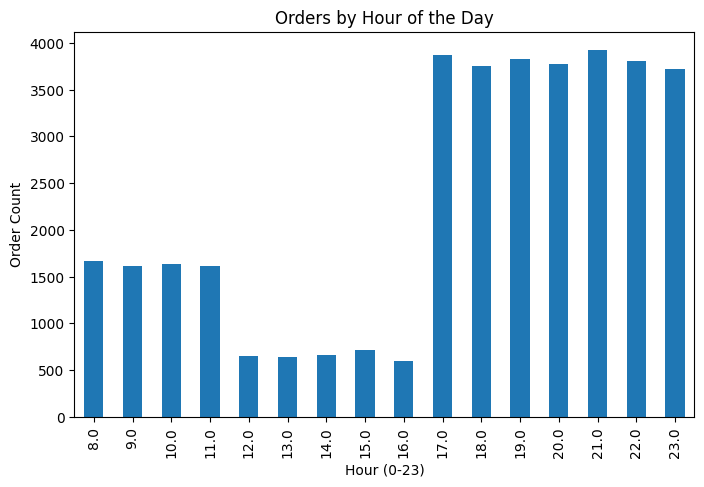

In [ ]:
#Number of orders per hour (Time of day)
plt.figure(figsize=(8,5))
df_clean["Order_Hour"].value_counts().sort_index().plot(kind='bar')
plt.title("Orders by Hour of the Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Order Count")
plt.show()

**Interpretation**

Delivery operations have two main peak hours—around lunchtime (morning/afternoon) and especially at dinnertime (evening/night). The evening peak hours (5:00 p.m. to 11:00 p.m.) are a critical period with order volumes more than double those of the morning/afternoon peak hours, and far exceeding the quiet period in the middle of the day.

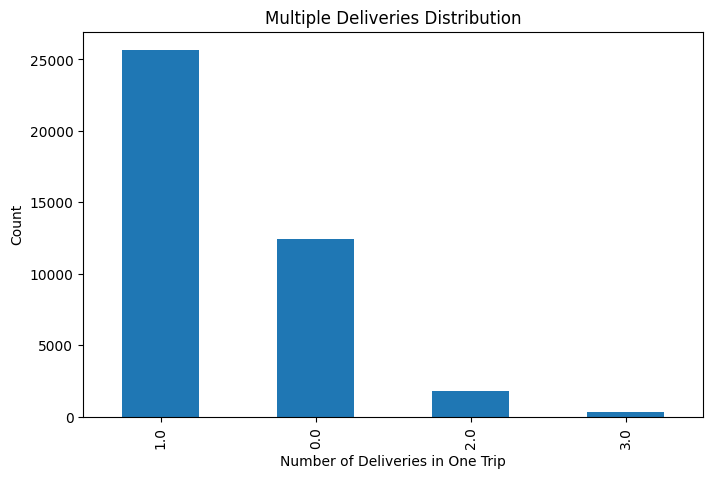

In [ ]:
#Multiple delivers pattern
plt.figure(figsize=(8,5))
df_clean["multiple_deliveries"].value_counts().plot(kind='bar')
plt.title("Multiple Deliveries Distribution")
plt.xlabel("Number of Deliveries in One Trip")
plt.ylabel("Count")
plt.show()

**Intepretation**

The distribution of multiple_deliveries shows that most deliveries are made with two orders in one trip (23,062 orders), indicating that the batch delivery strategy is quite often used to improve efficiency in areas with high demand. Deliveries with only one order remain common (11,164 orders), while larger batches such as three (1,578 orders) or four orders (282 orders) are much rarer and likely only occur in very dense zones. Overall, this pattern shows a combination of normal deliveries and efficient order consolidation without any indication of cancellations, which can be used to understand driver workload and route optimization needs in each area.

## Clustering Based on Environmental & Route Condition Features

In [ ]:
#Define features
num_features = [
    'Delivery_location_latitude',
    'Delivery_location_longitude',
]

cat_features = [
    'Road_traffic_density',
    'Weather_conditions',
]

### Encoding + Scaling

In [ ]:
#Encoding + Scaling pipeline >> Encoding using One Hot Encoder and Scaling using StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first"), cat_features)
    ]
)

# Transform data
df_cluster = preprocessor.fit_transform(df_clean)

In [ ]:
# Convert to DataFrame to inspect results
col_names = (
    num_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features))
)
df_transformed = pd.DataFrame(df_cluster, columns=col_names)

print(df_transformed.head())

   Delivery_location_latitude  Delivery_location_longitude  \
0                    2.092699                     0.327157   
1                   -1.632731                    -0.179249   
2                   -0.057010                    -0.849575   
3                    2.188167                    -0.327645   
4                    1.396392                     1.010613   

   Road_traffic_density_Jam  Road_traffic_density_Low  \
0                       1.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       1.0   
4                       1.0                       0.0   

   Road_traffic_density_Medium  Weather_conditions_Fog  \
0                          0.0                     1.0   
1                          0.0                     0.0   
2                          1.0                     0.0   
3                          0.0                     0

### Find Optimal K

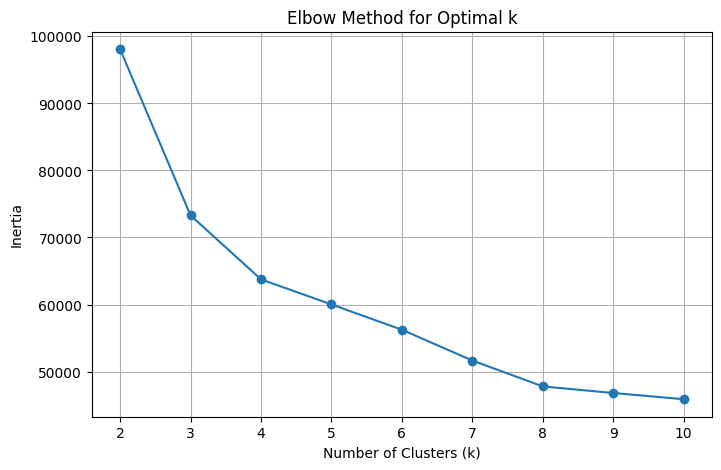

In [ ]:
K = range(2, 11) # Define K as a range from 2 to 11 for testing clusters
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster)
    inertia.append(kmeans.inertia_)

# Plot elbow method
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

**Interpretation**

The Elbow Method shows a sharp decrease in inertia at the beginning (K=2 to K=3), then begins to level off after K=3, indicating that adding more clusters after that point does not provide a significant improvement in cluster separation. The most obvious “elbow” point is around K = 3, so this number of clusters is considered most effective because it captures data variation without over-clustering the model. In other words, K=3 provides the best balance between complexity and delivery zone mapping quality.

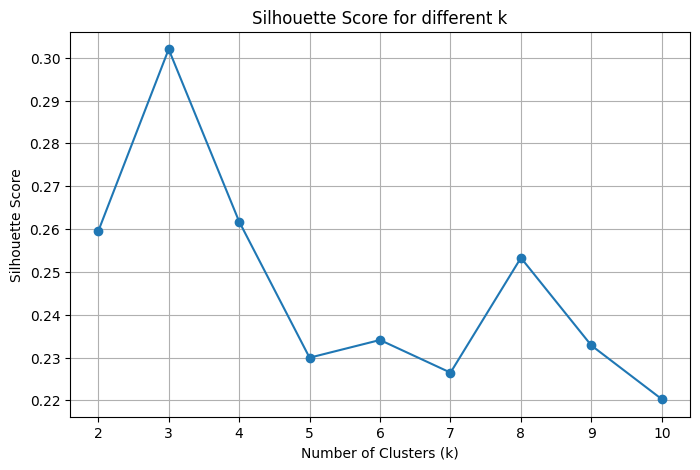

In [ ]:
#Silhouette Score
sil_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_cluster)
    score = silhouette_score(df_cluster, labels)
    sil_scores.append(score)

#Silhouette Plot
plt.figure(figsize=(8,5))
plt.plot(K, sil_scores, marker='o')
plt.title('Silhouette Score for different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**Interpretation**

The Silhouette Score graph shows that the highest value is at K = 3, which means that the clusters at K have the clearest separation and the most stable structure. The silhouette value increases significantly from K=2 to K=3, then decreases again afterwards, indicating that K > 3 causes the clusters to overlap and become less defined. Since the silhouette score measures how similar a point is to its own cluster compared to other clusters, these results confirm that K=3 is the most natural number of clusters when considering location, weather conditions, traffic, and other delivery factors.

### K-Means Clustering using Environmental Features

In [ ]:
# Fit K-Means
k_optimal = 3 #Result from elbow and Silhouette
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_clean['kmeans_cluster_features'] = kmeans.fit_predict(df_cluster)
df_clean['kmeans_cluster_features'].value_counts()

/tmp/ipython-input-1646966382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['kmeans_cluster_features'] = kmeans.fit_predict(df_cluster)


,count
kmeans_cluster_features,
0,19611
1,16316
2,4261


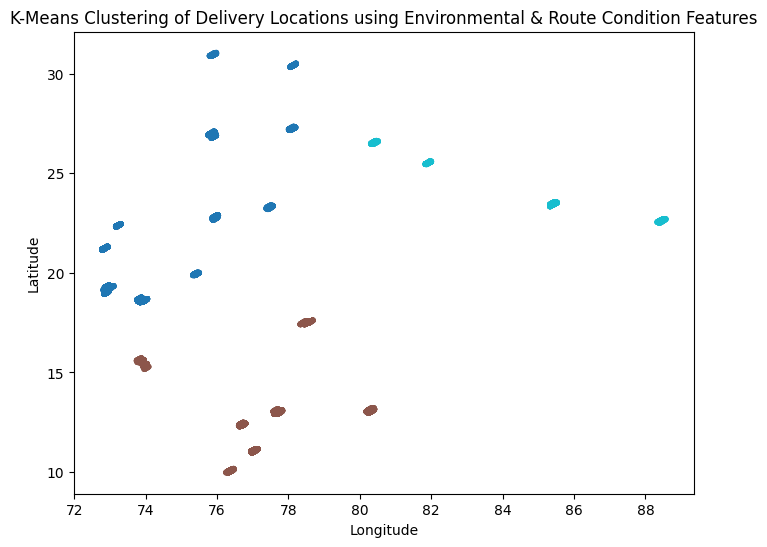

In [ ]:
#Plot cluster using scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df_clean['Delivery_location_longitude'],
            df_clean['Delivery_location_latitude'],
            c=df_clean['kmeans_cluster_features'], cmap='tab10', s=10)
plt.title("K-Means Clustering of Delivery Locations using Environmental & Route Condition Features")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

**Intepretation**

1. Cluster 0 — Northern Region with Very High Delivery Concentration (19,611 locations)

    This cluster has a relatively high latitude value, indicating that deliveries occur mostly in the northern part of the operational area. The large amount of data suggests that this region is likely the largest logistics hub, such as an urban area or residential center with high demand for services.

2. Cluster 1 — Southern Region with High Logistics Activity (16,316 locations)

    This cluster is located at a lower latitude, which means it covers the southern region. Although not as large as Cluster 0, this region still has a large volume of shipments, so it can be considered the second center of activity. The geographical differences between Clusters 0 and 1 indicate the existence of two relatively balanced main service centers.

3. Cluster 2 — More Remote and Spread Out Eastern Region (4,261 locations)

    This cluster has a much higher longitude value than other clusters, indicating a more easterly location. The smaller amount of data and the tendency for it to be scattered rather than concentrated indicates that this region is an area with low shipping intensity, possibly consisting of outlying areas or regions that are not included in the main service area.

/tmp/ipython-input-299582822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pca1'] = pca_result[:,0]
/tmp/ipython-input-299582822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pca2'] = pca_result[:,1]


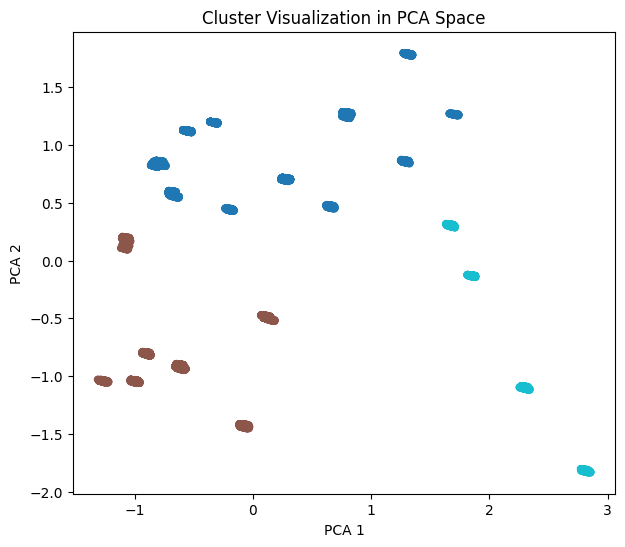

In [ ]:
# Dimensional reduction using PCA to simplify the data while retaining the most important information so that the plot is clearer
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_cluster)

df_clean['pca1'] = pca_result[:,0]
df_clean['pca2'] = pca_result[:,1]

#PCA plot
plt.figure(figsize=(7,6))
plt.scatter(df_clean['pca1'], df_clean['pca2'],
            c=df_clean['kmeans_cluster_features'], cmap='tab10', s=20)
plt.title("Cluster Visualization in PCA Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [ ]:
# Evaluate
sil = silhouette_score(df_cluster, df_clean['kmeans_cluster_features'])
sil

np.float64(0.301984804114486)

In [ ]:
#Define center of latitude and longitude
center_lat = df_clean['Delivery_location_latitude'].mean()
center_lon = df_clean['Delivery_location_longitude'].mean()

#Make a base map
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

#Get map based on clustering result
for _, row in df_clean.iterrows():
    folium.CircleMarker(
        location=[row['Delivery_location_latitude'], row['Delivery_location_longitude']],
        radius=4,
        color=colors[row['kmeans_cluster_features'] % len(colors)],
        fill=True,
        fill_opacity=0.7,
        popup=f"Cluster: {row['kmeans_cluster_features']}"
    ).add_to(m)

#Show map
m

Buffered data was truncated after reaching the output size limit.

In [ ]:
#Save to deploy
df_clean.to_csv("clustering zomato.csv", index=False)

### Cluster Summary

In [ ]:
#Make a cluster summary based on the result of clustering and multifeatures that have been applied
cluster_env = df_clean.groupby("kmeans_cluster_features").agg({
    "Delivery_location_latitude": ["mean"],
    "Delivery_location_longitude": ["mean"],
    "Road_traffic_density": lambda x: x.value_counts().idxmax(),
    "Weather_conditions": lambda x: x.value_counts().idxmax(),
    "kmeans_cluster_features": "count"
})

cluster_env.columns = [
    "lat_mean", "lon_mean", "dominant_traffic",
    "dominant_weather", "order_count_env"
]
cluster_env

,lat_mean,lon_mean,dominant_traffic,dominant_weather,order_count_env
kmeans_cluster_features,,,,,
0,22.523906,74.580486,Low,Fog,19611
1,13.364025,77.835554,Low,Stormy,16316
2,24.022292,84.687011,Low,Sandstorms,4261


**Interpretation**

1. Cluster 0 — West-Central Region with Foggy Weather

    This cluster covers approximately 19,611 data points, making it the largest delivery area. This area is located at coordinates of approximately 22.52° latitude and 74.58° longitude, with traffic conditions that tend to be low. The dominant weather condition is fog, so potential obstacles arise from reduced visibility. However, the low traffic density indicates that this area is not a congested urban center, so deliveries remain relatively stable despite less than ideal weather conditions.

2. Cluster 1 — South-Central Region with Stormy Weather

    With 16,316 data points, this cluster is the second largest shipping region. It is located at approximately 13.36° latitude and 77.83° longitude, with low traffic levels. The main challenge in this region stems from stormy weather, which can increase travel risks and slow down the delivery process. Although traffic is not heavy, the intensity of extreme weather means that this region requires extra attention in terms of route management, safety, and scheduling.

3. Cluster 2 — Eastern Region with Sandy Weather

    This cluster includes 4,261 data points, making it the region with the lowest shipping volume. Located at approximately 24.02° latitude and 84.69° longitude, this region is in the eastern part of the country with low traffic conditions. The dominant weather condition is sandstorms, indicating a drier and more extreme environment. These conditions have the potential to complicate shipments, both due to the greater distance between locations and due to weather disturbances that reduce visibility and increase risk during travel.

## Expected Delivery Time per Cluster (Simple SLA Predictor)

In [ ]:
#cluster summary by time
cluster_time = df_clean.groupby("kmeans_cluster_features")["Time_taken (min)"].agg(
    ['mean', 'median', 'std']
).rename(columns={
    "mean": "avg_time",
    "median": "median_time",
    "std": "std_dev"
})
cluster_time

,avg_time,median_time,std_dev
kmeans_cluster_features,,,
0,26.329713,26.0,9.364673
1,26.248774,25.0,9.358692
2,26.516780,26.0,9.483641


In [ ]:
#Join
cluster_summary = cluster_env.join(cluster_time)

In [ ]:
#SLA calculation
cluster_summary["sla_time"] = cluster_summary["avg_time"] + cluster_summary["std_dev"]
cluster_summary = cluster_summary.reset_index()

cluster_summary

,kmeans_cluster_features,lat_mean,lon_mean,dominant_traffic,dominant_weather,order_count_env,avg_time,median_time,std_dev,sla_time
0,0,22.523906,74.580486,Low,Fog,19611,26.329713,26.0,9.364673,35.694386
1,1,13.364025,77.835554,Low,Stormy,16316,26.248774,25.0,9.358692,35.607466
2,2,24.022292,84.687011,Low,Sandstorms,4261,26.516780,26.0,9.483641,36.000421


In [ ]:
#Save for deploy
cluster_summary.to_csv("cluster_summary.csv", index=False)

## Conclusion

Based on the geospatial clustering analysis of customer orders:

1. Delivery distances and operational costs can be reduced

* The clusters show that customers naturally group into specific zones. Assigning drivers to these clusters reduces the need to travel across wide areas.

* For example, Cluster 0 (16,110 orders) is concentrated around latitude 22.52 and longitude 74.58, allowing targeted routing instead of random assignment.

2. Delivery consistency can be improved

* Average delivery times across clusters are similar (≈26–27 min), but standard deviations differ slightly (≈9–9.5 min), indicating some variability within zones.

* By monitoring SLA per cluster, Zomato can ensure predictable delivery times and address outliers.

3. Operational visibility is enhanced

* Clusters provide a clear mapping of high-demand areas, traffic, and weather patterns, enabling data-driven decisions for resource allocation, driver scheduling, and contingency planning.

## Recommendations

1. Assign drivers per cluster

* Allocate dedicated drivers to each delivery zone (cluster) to minimize travel distances and improve consistency.

* For example:

  Cluster 0 → 16,000+ orders → 10–12 drivers

  Cluster 1 → 13,400+ orders → 8–10 drivers

  Cluster 2 → 3,500 orders → 2–3 drivers

2. Optimize routes within each cluster

* Use routing algorithms (e.g., Google OR-Tools or TSP solver) to define shortest/fastest paths within each cluster, considering traffic and weather conditions.

3. Monitor SLA and performance per cluster

* Track average, median, and standard deviation of delivery times per cluster.

* Identify clusters with higher variability (e.g., Cluster 2 with std_dev ≈ 9.5 min) for targeted operational improvements.

4. Dynamic resource allocation for external factors

* Adjust driver allocation in real-time based on dominant weather or traffic per cluster.

* For example, Cluster 1 with “Stormy” conditions may need extra buffer time or additional drivers.

4. Data-driven zone adjustment

* Re-run clustering periodically (e.g., monthly) to account for changing order patterns, seasonality, or new delivery areas.